# Vehicle Detection Project

## Read in Data

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Read in car and non-car images function
def get_data():
    cars = []
    notcars = []

    notcar_files = glob.glob("non-vehicles/*")
    car_files = glob.glob("vehicles/*")

    for notcar_file in notcar_files:
        notcars_folder = glob.glob(notcar_file + "/*.png")
        notcars.append(notcars_folder)

    notcars = np.concatenate((notcars[0], notcars[1]))

    for car_file in car_files:
        cars_folder = glob.glob(car_file + "/*.png")
        cars.append(cars_folder)

    cars = np.concatenate((cars[0], cars[1], cars[2], cars[3], cars[4]))

    return cars, notcars



## Core Functions

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
%matplotlib inline

# Define a function to compute binned color features  
# Transform a 2D image with different channels into a 1D vector.
 # Use cv2.resize().ravel() to create the feature vector
def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel()


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
#Because .png read from 0 to 1
#Because .jpeg read from 0 to 255
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        hog_features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return hog_features, hog_image
    # Otherwise call with one output
    else:      
        hog_features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return hog_features



# Define the main function to extract features from a list of images
# Have this function call bin_spatial(), color_hist() and get_hog_features()
#Extract of all the images for training:
# -The histogram of each picture
# -The HOG features of each picture
#And then structure each image as an array with spatial bin
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis, feature_vec=True)) 
                
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel],
                                                           orient, pix_per_cell, cell_per_block, 
                                                           vis, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
#clf = classifier chosen
#scaler = tool to scale from sklearn to normalise all data
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

#Function taken from the Q&A to visualize images, Super useful!!
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    
def heatmap_thresh(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def label_thresh(labels, threshold):
    # Zero out pixels below the threshold
    labels[labels >= threshold] = 0
    # Return thresholded map
    return labels


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


## Visualize/Exploration Data

Number of non-car images:  8968
Number of car images:  8792
Size of images:  (64, 64, 3)


Text(0.5,1,'Non-car Image')

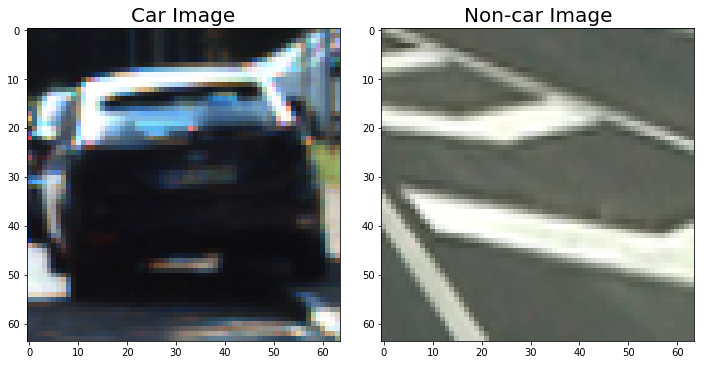

In [53]:
cars, notcars = get_data()

print("Number of non-car images: ",len(notcars))
print("Number of car images: ",len(cars))
print("Size of images: ", mpimg.imread(cars[10]).shape)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 9))
f.tight_layout()
ax1.imshow(mpimg.imread(cars[np.random.randint(0,len(cars))]))
ax1.set_title('Car Image', fontsize=20)
ax2.imshow(mpimg.imread(notcars[np.random.randint(0,len(notcars))]))
ax2.set_title('Non-car Image', fontsize=20)

## Display HOG & original

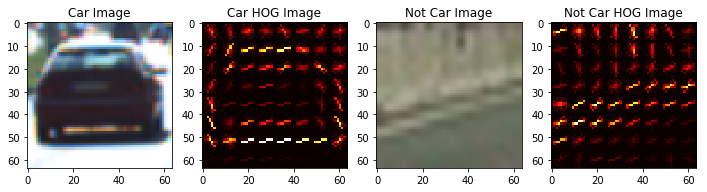

In [59]:
car_img = mpimg.imread(cars[np.random.randint(0,len(cars))])
notcar_img = mpimg.imread(notcars[np.random.randint(0,len(notcars))])


### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1# 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 20    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [490, None] # Min and max in y to search in slide_window()


car_features, car_hog_img = single_img_features(car_img, color_space=color_space, 
                                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                                orient=orient, pix_per_cell=pix_per_cell, 
                                                cell_per_block=cell_per_block, 
                                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_img = single_img_features(notcar_img, color_space=color_space, 
                                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                                orient=orient, pix_per_cell=pix_per_cell, 
                                                cell_per_block=cell_per_block, 
                                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                hist_feat=hist_feat, hog_feat=hog_feat, vis=True)



# # Plot the 2 images side by side
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 9))
# f.tight_layout()
# ax1.imshow(car_img)
# ax1.set_title('Car Image', fontsize=20)
# ax2.imshow(car_hog_img)
# ax2.set_title('Car Image HOG', fontsize=20)
images = [car_img,car_hog_img,notcar_img,notcar_hog_img]
titles = ['Car Image','Car HOG Image','Not Car Image','Not Car HOG Image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)


## Train

In [ ]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations Improves upt to 9 then levels
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 60    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
#print(random_idxs)
#This is a way of choosing lots of images with a random array of indexes (Useful!!)
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(notcars)[random_idxs]



car_features = extract_features(cars, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)

notcar_features = extract_features(notcars, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)


print(time.time()-t, 'Seconds to compute features')

#Stack features, each feature vector represent a row 
#Stacks vertically
#Output an array
X = np.vstack((car_features, notcar_features)).astype(np.float64)     
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
#Array of 1s for cars and array of 0s for notcars
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell,', cell_per_block,'cells per block,', hist_bins, 'histogram bins and',spatial_size, 'spatial sampling' )
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()




In [ ]:
#Save model

joblib.dump(svc, 'SavedModelAcc0_99270.pkl')

#History of models

#SavedModelAcc0_9896
# color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 6  # HOG orientations Improves upt to 9 then levels
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 60    # Number of histogram bins
# 0.2 split train-test

#SavedModelAcc0_9906
# color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 6  # HOG orientations Improves upt to 9 then levels
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 60    # Number of histogram bins
# 0.15 split train-test

#SavedModelAcc0_9921
# color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 6  # HOG orientations Improves upt to 9 then levels
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 60    # Number of histogram bins
# 0.2 split train-test

#SavedModelAcc0_9907
#Awful, loads of false detections
# color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 6  # HOG orientations Improves upt to 9 then levels
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 60    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off
# 0.2 split train-test

#SavedModelAcc0_9924
#Still Awful
# color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9  # HOG orientations Improves upt to 9 then levels
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 60    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off
# 0.2 split train-test

#SavedModelAcc0_99270
# color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9  # HOG orientations Improves upt to 9 then levels
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 60    # Number of histogram bins


#Fuck you also have to save the feature vectors otherwise it won't work...obviously!

# Use previous Model

## Output Saved Model

In [5]:
#Import model
svc = joblib.load('SavedModelAcc0_99270.pkl')

## Output Features

Better to have used something like pickle file to save the features list, definitely something to do in the next projects!

In [60]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations Improves upt to 9 then levels
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 60    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


t=time.time()
car_features = extract_features(cars, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)

notcar_features = extract_features(notcars, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)


print(time.time()-t, 'Seconds to compute features')

#Stack features, each feature vector represent a row (or column?)
#Stacks vertically
#Output an array
X = np.vstack((car_features, notcar_features)).astype(np.float64)     
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

114.21178007125854 Seconds to compute features
(17760, 8544)


# Window Slider

In [7]:
img_files = glob.glob('test_images/*')

D:\Programs\Miniconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Image processed with a time of 1.9312007427215576 and this amount of windows: 380
Image processed with a time of 2.118389129638672 and this amount of windows: 380
Image processed with a time of 1.9973149299621582 and this amount of windows: 380
Image processed with a time of 1.9672796726226807 and this amount of windows: 380
Image processed with a time of 2.148810863494873 and this amount of windows: 380
Image processed with a time of 2.1697723865509033 and this amount of windows: 380


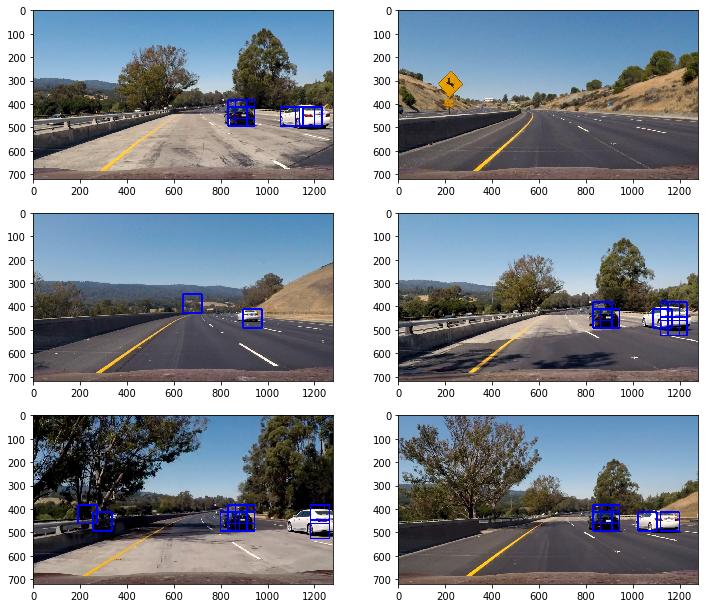

In [8]:
y_start_stop = [350, None] # Min and max in y to search in slide_window()

img_with_boxes = []
titles = []

for img_file in img_files:
    t0 = time.time()
    image = mpimg.imread(img_file)
    draw_image = np.copy(image)
    #Convert to .png format by ranging the image between 0 and 1
    image = image.astype(np.float32)/255
    
    #xy_window is the size of the window
    #xy overlap distance between widow and window
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                           xy_window=(80, 80), xy_overlap=(0.6, 0.6))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)     
    print("Image processed with a time of", time.time()-t0,'and this amount of windows:', len(windows))
    img_with_boxes.append(window_img)
    titles.append('')

fig = plt.figure(figsize=(12,18))
visualize(fig, 5, 2, img_with_boxes, titles)


## Take HOG of the Image and then classify each window

D:\Programs\Miniconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.83378005027771 seconds, and number of windows:  760
0.81667160987854 seconds, and number of windows:  760
0.8156700134277344 seconds, and number of windows:  760
0.8136641979217529 seconds, and number of windows:  760
0.9034225940704346 seconds, and number of windows:  760
1.0032134056091309 seconds, and number of windows:  760


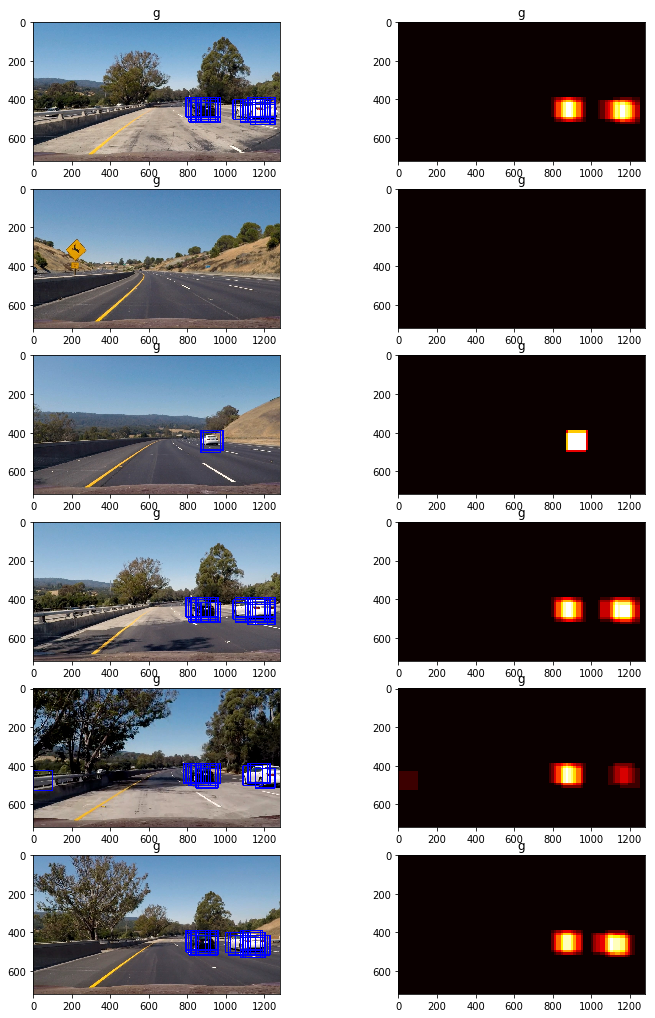

In [13]:
ystart= 390
ystop= 656
out_imgs = []
out_titles = []
scale = 1.6

for img_file in img_files:
    count = 0
    t0 = time.time()
    img = mpimg.imread(img_file)
    draw_image = np.copy(img)
    img = img.astype(np.float32)/255
    heatmap = np.zeros_like(img[:,:,0])
    #Constrain area to search
    img_tosearch = img[ystart:ystop,:,:]
    #Color transform
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    # // divide and make sure output is integer
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1.1  # Instead of overlap, define how many cells to step
    nxsteps = int((nxblocks - nblocks_per_window) // cells_per_step)
    nysteps = int((nyblocks - nblocks_per_window) // cells_per_step)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1 
            ypos = int(yb*cells_per_step)
            xpos = int(xb*cells_per_step)
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = int(xpos*pix_per_cell)
            ytop = int(ypos*pix_per_cell)

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #IMPORTANT: Stack featuers the same way as trained
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_image,bbox[0],bbox[1],(0,0,255),6)
                heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] +=1
            
                
                
    print(time.time()-t0, 'seconds, and number of windows: ', count)
    
    out_imgs.append(draw_image) 
    out_imgs.append(heatmap) 
    
    out_titles.append(img_file[-1])
    out_titles.append(img_file[-1])


fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_imgs, out_titles)    
            
    
    

## Wrap it as a function

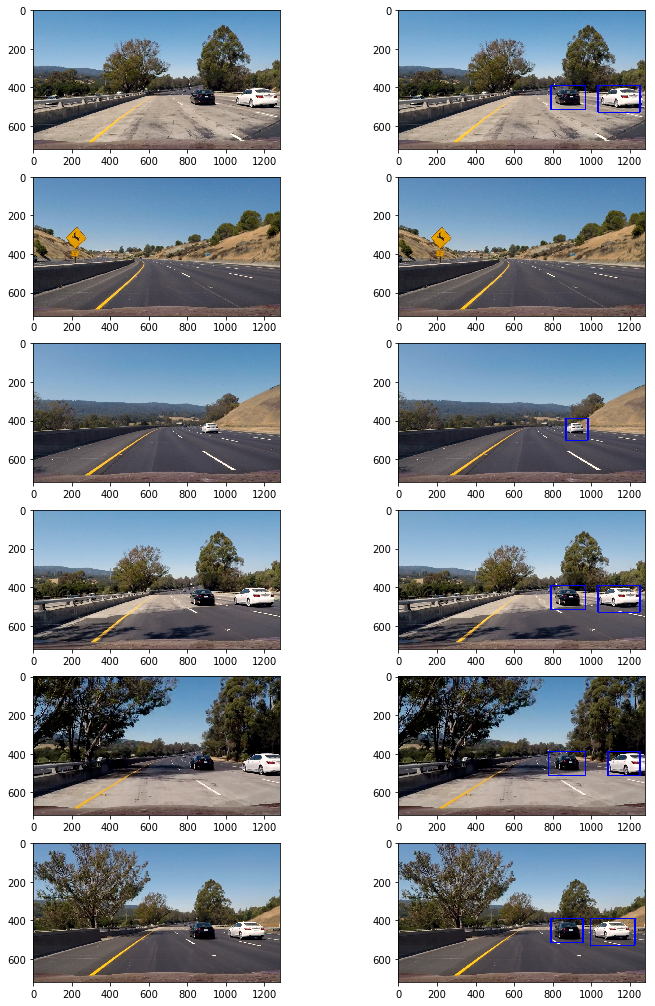

In [67]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img  

#Parse the image that wants to be classified
def find_cars(img, show_heatmap = False, show_gray_squares = False, show_squares = False, m = False):
    predictions = []
    scale = 1.6
    ystart= 390
    ystop= 656

    orient = 9  # HOG orientations Improves upt to 9 then levels
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block

    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 60    # Number of histogram bins
    
    draw_image = np.copy(img)
    image = np.copy(img)
    img = img.astype(np.float32)/255
    heatmap = np.zeros_like(img[:,:,0])
    #Constrain area to search
    img_tosearch = img[ystart:ystop,:,:]
    #Color transform
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    # // divide and make sure output is integer
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1.1  # Instead of overlap, define how many cells to step #1.7
    nxsteps = int((nxblocks - nblocks_per_window) // cells_per_step)
    nysteps = int((nyblocks - nblocks_per_window) // cells_per_step)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = int(yb*cells_per_step)
            xpos = int(xb*cells_per_step)
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = int(xpos*pix_per_cell)
            ytop = int(ypos*pix_per_cell)

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #IMPORTANT: Stack featuers the same way as trained
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_image,bbox[0],bbox[1],(0,0,255),6)
                heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] +=1
                
                labels = label(heatmap)
                predictions.append(test_prediction)
    
    #if show_heatmap == True:
    heatmap = heatmap_thresh(heatmap, threshold=0.9)
    #heatmap = heatmap_thresh(heatmap, threshold=0.9)

    if 1 in predictions:
        labels = label(heatmap)
        img_label = labels[0]
        img_label = label_thresh(labels[0], threshold = 3)
        labels = label(img_label)
        #labels[0] = img_label
        draw_squares = draw_labeled_bboxes(image,labels)        
        return draw_squares
        #return img_label
    else:
        #print("No car found")
        return image
    
#     if m == True:
#         heatmap = heatmap_thresh(heatmap, threshold=1)
#         labels = label(heatmap)
        
#         img_label = labels[0]
#         img_label = label_thresh(labels[0], threshold =2)
#         draw_squares = draw_labeled_bboxes(img, label(heatmap))
#         print(labels[1])
#         return draw_squares
        
    
#     if show_gray_squares == True:
#         if test_prediction == 1:
#             labels = label(heatmap)
#             img_label = labels[0]
#             print("Number of cars detected: ", labels[1])
#             return img_label
#         else:
#             print("No cars found")
#             return img
        
#     if show_squares == True:
#         if test_prediction == 1:
#             print("Number of cars detected: ", labels[1])
#             draw_squares = draw_labeled_bboxes(img, labels)        
#             return draw_squares
#         else:
#             print("No cars found")
#             return img
    
titles = []
images_out = []
i = 0
for img_file in img_files:
    img = mpimg.imread(img_file)
    result = find_cars(img)    
    
#     fig, img = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
#     img.imshow(result)
#     fig.savefig('output_images/{}.jpg'.format(i))   # save the figure to file
#     plt.close(fig)
#     plt.imshow(result)
    
    images_out.append(img)
    images_out.append(result)
    titles.append('')
    titles.append('')
    i +=1


    
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, images_out, titles)  
    


# image_example = mpimg.imread(img_files[4])
# result = find_cars(image_example)
# plt.imshow(result)




## Video

In [48]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#The video output will be called:
output_video = 'output_video/project_video_output.mp4'

#Get this video as input
input_video = VideoFileClip('project_video.mp4')#.subclip(t_start='00:00:23.90')

#For each frame of the video_input do the required processing
processed_video = input_video.fl_image(find_cars)

#Save and show time processing bar
%time processed_video.write_videofile(output_video, audio=False)

#First video with both thresholds
#Second only in label
#Third only in label, as heatmap had some false positivies but this time with 1.5 cells per step


2
[MoviePy] >>>> Building video output_video/project_video_output.mp4
[MoviePy] Writing video output_video/project_video_output.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

3


  0%|                                                                                 | 1/1261 [00:01<38:43,  1.84s/it]

1


  0%|▏                                                                                | 2/1261 [00:03<37:55,  1.81s/it]

2


  0%|▏                                                                                | 3/1261 [00:05<37:23,  1.78s/it]

3


  0%|▎                                                                                | 4/1261 [00:07<37:28,  1.79s/it]

1


  0%|▎                                                                                | 5/1261 [00:08<36:56,  1.77s/it]

2


  0%|▍                                                                                | 6/1261 [00:10<37:06,  1.77s/it]

3


  1%|▍                                                                                | 7/1261 [00:12<37:02,  1.77s/it]

1


  1%|▌                                                                                | 8/1261 [00:14<37:00,  1.77s/it]

2


  1%|▌                                                                                | 9/1261 [00:15<36:52,  1.77s/it]

3


  1%|▋                                                                               | 10/1261 [00:17<37:02,  1.78s/it]

1


  1%|▋                                                                               | 11/1261 [00:19<37:00,  1.78s/it]

2


  1%|▊                                                                               | 12/1261 [00:21<36:54,  1.77s/it]

3


  1%|▊                                                                               | 13/1261 [00:22<36:39,  1.76s/it]

1


  1%|▉                                                                               | 14/1261 [00:24<36:18,  1.75s/it]

2


  1%|▉                                                                               | 15/1261 [00:26<36:13,  1.74s/it]

3


  1%|█                                                                               | 16/1261 [00:28<36:02,  1.74s/it]

1


  1%|█                                                                               | 17/1261 [00:29<36:11,  1.75s/it]

2


  1%|█▏                                                                              | 18/1261 [00:31<36:00,  1.74s/it]

3


  2%|█▏                                                                              | 19/1261 [00:33<35:54,  1.73s/it]

1


  2%|█▎                                                                              | 20/1261 [00:35<35:42,  1.73s/it]

2


  2%|█▎                                                                              | 21/1261 [00:36<35:40,  1.73s/it]

3


  2%|█▍                                                                              | 22/1261 [00:38<35:39,  1.73s/it]

1


  2%|█▍                                                                              | 23/1261 [00:40<35:37,  1.73s/it]

2


  2%|█▌                                                                              | 24/1261 [00:42<36:48,  1.79s/it]

3


  2%|█▌                                                                              | 25/1261 [00:43<36:25,  1.77s/it]

1


  2%|█▋                                                                              | 26/1261 [00:45<36:34,  1.78s/it]

2


  2%|█▋                                                                              | 27/1261 [00:47<36:24,  1.77s/it]

3


  2%|█▊                                                                              | 28/1261 [00:49<36:01,  1.75s/it]

1


  2%|█▊                                                                              | 29/1261 [00:50<36:29,  1.78s/it]

2


  2%|█▉                                                                              | 30/1261 [00:52<36:12,  1.76s/it]

3


  2%|█▉                                                                              | 31/1261 [00:54<35:48,  1.75s/it]

1


  3%|██                                                                              | 32/1261 [00:56<36:06,  1.76s/it]

2


  3%|██                                                                              | 33/1261 [00:57<35:21,  1.73s/it]

3


  3%|██▏                                                                             | 34/1261 [00:58<31:00,  1.52s/it]

1


  3%|██▏                                                                             | 35/1261 [00:59<27:30,  1.35s/it]

2


  3%|██▎                                                                             | 36/1261 [01:00<24:37,  1.21s/it]

3


  3%|██▎                                                                             | 37/1261 [01:01<22:42,  1.11s/it]

1


  3%|██▍                                                                             | 38/1261 [01:02<21:19,  1.05s/it]

2


  3%|██▍                                                                             | 39/1261 [01:03<20:21,  1.00it/s]

3


  3%|██▌                                                                             | 40/1261 [01:04<19:35,  1.04it/s]

1


  3%|██▌                                                                             | 41/1261 [01:05<18:50,  1.08it/s]

2


  3%|██▋                                                                             | 42/1261 [01:05<18:30,  1.10it/s]

3


  3%|██▋                                                                             | 43/1261 [01:06<18:28,  1.10it/s]

1


  3%|██▊                                                                             | 44/1261 [01:07<18:06,  1.12it/s]

2


  4%|██▊                                                                             | 45/1261 [01:08<17:56,  1.13it/s]

3


  4%|██▉                                                                             | 46/1261 [01:09<17:57,  1.13it/s]

1


  4%|██▉                                                                             | 47/1261 [01:10<18:00,  1.12it/s]

2


  4%|███                                                                             | 48/1261 [01:11<17:51,  1.13it/s]

3


  4%|███                                                                             | 49/1261 [01:12<17:50,  1.13it/s]

1


  4%|███▏                                                                            | 50/1261 [01:13<17:51,  1.13it/s]

2


  4%|███▏                                                                            | 51/1261 [01:13<17:48,  1.13it/s]

3


  4%|███▎                                                                            | 52/1261 [01:14<17:47,  1.13it/s]

1


  4%|███▎                                                                            | 53/1261 [01:15<17:58,  1.12it/s]

2


  4%|███▍                                                                            | 54/1261 [01:16<17:54,  1.12it/s]

3


  4%|███▍                                                                            | 55/1261 [01:17<17:52,  1.12it/s]

1


  4%|███▌                                                                            | 56/1261 [01:18<17:48,  1.13it/s]

2


  5%|███▌                                                                            | 57/1261 [01:19<17:42,  1.13it/s]

3


  5%|███▋                                                                            | 58/1261 [01:20<17:44,  1.13it/s]

1


  5%|███▋                                                                            | 59/1261 [01:21<17:45,  1.13it/s]

2


  5%|███▊                                                                            | 60/1261 [01:21<17:41,  1.13it/s]

3


  5%|███▊                                                                            | 61/1261 [01:22<17:34,  1.14it/s]

1


  5%|███▉                                                                            | 62/1261 [01:23<17:37,  1.13it/s]

2


  5%|███▉                                                                            | 63/1261 [01:24<17:43,  1.13it/s]

3


  5%|████                                                                            | 64/1261 [01:25<17:40,  1.13it/s]

1


  5%|████                                                                            | 65/1261 [01:26<17:44,  1.12it/s]

2


  5%|████▏                                                                           | 66/1261 [01:27<17:33,  1.13it/s]

3


  5%|████▎                                                                           | 67/1261 [01:28<17:28,  1.14it/s]

1


  5%|████▎                                                                           | 68/1261 [01:28<17:22,  1.14it/s]

2


  5%|████▍                                                                           | 69/1261 [01:29<17:26,  1.14it/s]

3


  6%|████▍                                                                           | 70/1261 [01:30<17:19,  1.15it/s]

1


  6%|████▌                                                                           | 71/1261 [01:31<17:17,  1.15it/s]

2


  6%|████▌                                                                           | 72/1261 [01:32<17:22,  1.14it/s]

3


  6%|████▋                                                                           | 73/1261 [01:33<17:13,  1.15it/s]

1


  6%|████▋                                                                           | 74/1261 [01:34<17:13,  1.15it/s]

2


  6%|████▊                                                                           | 75/1261 [01:35<17:15,  1.15it/s]

3


  6%|████▊                                                                           | 76/1261 [01:35<17:14,  1.15it/s]

1


  6%|████▉                                                                           | 77/1261 [01:36<17:14,  1.14it/s]

2


  6%|████▉                                                                           | 78/1261 [01:37<17:09,  1.15it/s]

3


  6%|█████                                                                           | 79/1261 [01:38<17:06,  1.15it/s]

1


  6%|█████                                                                           | 80/1261 [01:39<17:08,  1.15it/s]

2


  6%|█████▏                                                                          | 81/1261 [01:40<17:26,  1.13it/s]

3


  7%|█████▏                                                                          | 82/1261 [01:41<17:25,  1.13it/s]

1


  7%|█████▎                                                                          | 83/1261 [01:42<17:19,  1.13it/s]

2


  7%|█████▎                                                                          | 84/1261 [01:42<17:19,  1.13it/s]

3


  7%|█████▍                                                                          | 85/1261 [01:43<17:23,  1.13it/s]

1


  7%|█████▍                                                                          | 86/1261 [01:44<17:25,  1.12it/s]

2


  7%|█████▌                                                                          | 87/1261 [01:45<17:34,  1.11it/s]

3


  7%|█████▌                                                                          | 88/1261 [01:46<17:39,  1.11it/s]

1


  7%|█████▋                                                                          | 89/1261 [01:47<17:30,  1.12it/s]

2


  7%|█████▋                                                                          | 90/1261 [01:48<17:20,  1.13it/s]

3


  7%|█████▊                                                                          | 91/1261 [01:49<17:17,  1.13it/s]

1


  7%|█████▊                                                                          | 92/1261 [01:50<17:23,  1.12it/s]

2


  7%|█████▉                                                                          | 93/1261 [01:51<17:20,  1.12it/s]

3


  7%|█████▉                                                                          | 94/1261 [01:51<17:20,  1.12it/s]

1


  8%|██████                                                                          | 95/1261 [01:52<17:15,  1.13it/s]

2


  8%|██████                                                                          | 96/1261 [01:53<17:14,  1.13it/s]

3


  8%|██████▏                                                                         | 97/1261 [01:54<17:08,  1.13it/s]

1


  8%|██████▏                                                                         | 98/1261 [01:55<17:11,  1.13it/s]

2


  8%|██████▎                                                                         | 99/1261 [01:56<17:09,  1.13it/s]

3


  8%|██████▎                                                                        | 100/1261 [01:57<17:04,  1.13it/s]

1


  8%|██████▎                                                                        | 101/1261 [01:58<17:15,  1.12it/s]

2


  8%|██████▍                                                                        | 102/1261 [01:59<17:06,  1.13it/s]

3


  8%|██████▍                                                                        | 103/1261 [01:59<16:58,  1.14it/s]

1


  8%|██████▌                                                                        | 104/1261 [02:00<17:02,  1.13it/s]

2


  8%|██████▌                                                                        | 105/1261 [02:01<17:11,  1.12it/s]

3


  8%|██████▋                                                                        | 106/1261 [02:02<17:11,  1.12it/s]

1


  8%|██████▋                                                                        | 107/1261 [02:03<17:11,  1.12it/s]

2


  9%|██████▊                                                                        | 108/1261 [02:04<17:03,  1.13it/s]

3


  9%|██████▊                                                                        | 109/1261 [02:05<17:18,  1.11it/s]

1


  9%|██████▉                                                                        | 110/1261 [02:06<17:31,  1.09it/s]

2


  9%|██████▉                                                                        | 111/1261 [02:07<17:48,  1.08it/s]

3


  9%|███████                                                                        | 112/1261 [02:08<17:54,  1.07it/s]

1


  9%|███████                                                                        | 113/1261 [02:09<17:43,  1.08it/s]

2


  9%|███████▏                                                                       | 114/1261 [02:09<17:19,  1.10it/s]

3


  9%|███████▏                                                                       | 115/1261 [02:10<17:06,  1.12it/s]

1


  9%|███████▎                                                                       | 116/1261 [02:11<16:55,  1.13it/s]

2


  9%|███████▎                                                                       | 117/1261 [02:12<16:52,  1.13it/s]

3


  9%|███████▍                                                                       | 118/1261 [02:13<16:48,  1.13it/s]

1


  9%|███████▍                                                                       | 119/1261 [02:14<16:38,  1.14it/s]

2


 10%|███████▌                                                                       | 120/1261 [02:15<16:41,  1.14it/s]

3


 10%|███████▌                                                                       | 121/1261 [02:15<16:36,  1.14it/s]

1


 10%|███████▋                                                                       | 122/1261 [02:16<16:36,  1.14it/s]

2


 10%|███████▋                                                                       | 123/1261 [02:17<16:32,  1.15it/s]

3


 10%|███████▊                                                                       | 124/1261 [02:18<16:33,  1.14it/s]

1


 10%|███████▊                                                                       | 125/1261 [02:19<16:38,  1.14it/s]

2


 10%|███████▉                                                                       | 126/1261 [02:20<16:43,  1.13it/s]

3


 10%|███████▉                                                                       | 127/1261 [02:21<16:38,  1.14it/s]

1


 10%|████████                                                                       | 128/1261 [02:22<16:40,  1.13it/s]

2


 10%|████████                                                                       | 129/1261 [02:23<16:41,  1.13it/s]

3


 10%|████████▏                                                                      | 130/1261 [02:23<16:46,  1.12it/s]

1


 10%|████████▏                                                                      | 131/1261 [02:24<16:36,  1.13it/s]

2


 10%|████████▎                                                                      | 132/1261 [02:25<16:37,  1.13it/s]

3


 11%|████████▎                                                                      | 133/1261 [02:26<16:34,  1.13it/s]

1


 11%|████████▍                                                                      | 134/1261 [02:27<16:30,  1.14it/s]

2


 11%|████████▍                                                                      | 135/1261 [02:28<16:27,  1.14it/s]

3


 11%|████████▌                                                                      | 136/1261 [02:29<16:52,  1.11it/s]

1


 11%|████████▌                                                                      | 137/1261 [02:30<16:50,  1.11it/s]

2


 11%|████████▋                                                                      | 138/1261 [02:31<16:49,  1.11it/s]

3


 11%|████████▋                                                                      | 139/1261 [02:31<16:38,  1.12it/s]

1


 11%|████████▊                                                                      | 140/1261 [02:32<16:33,  1.13it/s]

2


 11%|████████▊                                                                      | 141/1261 [02:33<16:28,  1.13it/s]

3


 11%|████████▉                                                                      | 142/1261 [02:34<16:38,  1.12it/s]

1


 11%|████████▉                                                                      | 143/1261 [02:35<16:41,  1.12it/s]

2


 11%|█████████                                                                      | 144/1261 [02:36<16:32,  1.12it/s]

3


 11%|█████████                                                                      | 145/1261 [02:37<16:39,  1.12it/s]

1


 12%|█████████▏                                                                     | 146/1261 [02:38<16:34,  1.12it/s]

2


 12%|█████████▏                                                                     | 147/1261 [02:39<16:36,  1.12it/s]

3


 12%|█████████▎                                                                     | 148/1261 [02:39<16:29,  1.13it/s]

1


 12%|█████████▎                                                                     | 149/1261 [02:40<16:51,  1.10it/s]

2


 12%|█████████▍                                                                     | 150/1261 [02:41<16:54,  1.09it/s]

3


 12%|█████████▍                                                                     | 151/1261 [02:42<16:43,  1.11it/s]

1


 12%|█████████▌                                                                     | 152/1261 [02:43<16:44,  1.10it/s]

2


 12%|█████████▌                                                                     | 153/1261 [02:44<16:35,  1.11it/s]

3


 12%|█████████▋                                                                     | 154/1261 [02:45<16:52,  1.09it/s]

1


 12%|█████████▋                                                                     | 155/1261 [02:46<16:40,  1.11it/s]

2


 12%|█████████▊                                                                     | 156/1261 [02:47<16:25,  1.12it/s]

3


 12%|█████████▊                                                                     | 157/1261 [02:48<16:12,  1.14it/s]

1


 13%|█████████▉                                                                     | 158/1261 [02:48<16:12,  1.13it/s]

2


 13%|█████████▉                                                                     | 159/1261 [02:49<16:33,  1.11it/s]

3


 13%|██████████                                                                     | 160/1261 [02:50<16:22,  1.12it/s]

1


 13%|██████████                                                                     | 161/1261 [02:51<16:17,  1.13it/s]

2


 13%|██████████▏                                                                    | 162/1261 [02:52<16:12,  1.13it/s]

3


 13%|██████████▏                                                                    | 163/1261 [02:53<16:19,  1.12it/s]

1


 13%|██████████▎                                                                    | 164/1261 [02:54<16:19,  1.12it/s]

2


 13%|██████████▎                                                                    | 165/1261 [02:55<16:29,  1.11it/s]

3


 13%|██████████▍                                                                    | 166/1261 [02:56<16:30,  1.11it/s]

1


 13%|██████████▍                                                                    | 167/1261 [02:57<16:39,  1.09it/s]

2


 13%|██████████▌                                                                    | 168/1261 [02:58<16:42,  1.09it/s]

3


 13%|██████████▌                                                                    | 169/1261 [02:58<16:44,  1.09it/s]

1


 13%|██████████▋                                                                    | 170/1261 [02:59<16:46,  1.08it/s]

2


 14%|██████████▋                                                                    | 171/1261 [03:00<16:41,  1.09it/s]

3


 14%|██████████▊                                                                    | 172/1261 [03:01<16:50,  1.08it/s]

1


 14%|██████████▊                                                                    | 173/1261 [03:02<17:01,  1.07it/s]

2


 14%|██████████▉                                                                    | 174/1261 [03:03<17:00,  1.07it/s]

3


 14%|██████████▉                                                                    | 175/1261 [03:04<16:57,  1.07it/s]

1


 14%|███████████                                                                    | 176/1261 [03:05<17:09,  1.05it/s]

2


 14%|███████████                                                                    | 177/1261 [03:06<16:55,  1.07it/s]

3


 14%|███████████▏                                                                   | 178/1261 [03:07<16:46,  1.08it/s]

1


 14%|███████████▏                                                                   | 179/1261 [03:08<16:42,  1.08it/s]

2


 14%|███████████▎                                                                   | 180/1261 [03:09<16:35,  1.09it/s]

3


 14%|███████████▎                                                                   | 181/1261 [03:10<16:37,  1.08it/s]

1


 14%|███████████▍                                                                   | 182/1261 [03:11<16:44,  1.07it/s]

2


 15%|███████████▍                                                                   | 183/1261 [03:11<16:39,  1.08it/s]

3


 15%|███████████▌                                                                   | 184/1261 [03:12<16:46,  1.07it/s]

1


 15%|███████████▌                                                                   | 185/1261 [03:13<16:38,  1.08it/s]

2


 15%|███████████▋                                                                   | 186/1261 [03:14<16:45,  1.07it/s]

3


 15%|███████████▋                                                                   | 187/1261 [03:15<16:36,  1.08it/s]

1


 15%|███████████▊                                                                   | 188/1261 [03:16<16:31,  1.08it/s]

2


 15%|███████████▊                                                                   | 189/1261 [03:17<16:35,  1.08it/s]

3


 15%|███████████▉                                                                   | 190/1261 [03:18<16:38,  1.07it/s]

1


 15%|███████████▉                                                                   | 191/1261 [03:19<16:40,  1.07it/s]

2


 15%|████████████                                                                   | 192/1261 [03:20<16:46,  1.06it/s]

3


 15%|████████████                                                                   | 193/1261 [03:21<16:45,  1.06it/s]

1


 15%|████████████▏                                                                  | 194/1261 [03:22<16:45,  1.06it/s]

2


 15%|████████████▏                                                                  | 195/1261 [03:23<16:37,  1.07it/s]

3


 16%|████████████▎                                                                  | 196/1261 [03:24<16:37,  1.07it/s]

1


 16%|████████████▎                                                                  | 197/1261 [03:25<16:32,  1.07it/s]

2


 16%|████████████▍                                                                  | 198/1261 [03:26<16:32,  1.07it/s]

3


 16%|████████████▍                                                                  | 199/1261 [03:26<16:30,  1.07it/s]

1


 16%|████████████▌                                                                  | 200/1261 [03:27<16:23,  1.08it/s]

2


 16%|████████████▌                                                                  | 201/1261 [03:28<16:21,  1.08it/s]

3


 16%|████████████▋                                                                  | 202/1261 [03:29<16:20,  1.08it/s]

1


 16%|████████████▋                                                                  | 203/1261 [03:30<16:30,  1.07it/s]

2


 16%|████████████▊                                                                  | 204/1261 [03:31<16:28,  1.07it/s]

3


 16%|████████████▊                                                                  | 205/1261 [03:32<16:44,  1.05it/s]

1


 16%|████████████▉                                                                  | 206/1261 [03:33<16:52,  1.04it/s]

2


 16%|████████████▉                                                                  | 207/1261 [03:34<16:45,  1.05it/s]

3


 16%|█████████████                                                                  | 208/1261 [03:35<16:44,  1.05it/s]

1


 17%|█████████████                                                                  | 209/1261 [03:36<16:43,  1.05it/s]

2


 17%|█████████████▏                                                                 | 210/1261 [03:37<16:32,  1.06it/s]

3


 17%|█████████████▏                                                                 | 211/1261 [03:38<16:28,  1.06it/s]

1


 17%|█████████████▎                                                                 | 212/1261 [03:39<16:26,  1.06it/s]

2


 17%|█████████████▎                                                                 | 213/1261 [03:40<16:33,  1.05it/s]

3


 17%|█████████████▍                                                                 | 214/1261 [03:41<16:30,  1.06it/s]

1


 17%|█████████████▍                                                                 | 215/1261 [03:42<16:21,  1.07it/s]

2


 17%|█████████████▌                                                                 | 216/1261 [03:42<16:24,  1.06it/s]

3


 17%|█████████████▌                                                                 | 217/1261 [03:43<16:35,  1.05it/s]

1


 17%|█████████████▋                                                                 | 218/1261 [03:44<16:29,  1.05it/s]

2


 17%|█████████████▋                                                                 | 219/1261 [03:45<16:24,  1.06it/s]

3


 17%|█████████████▊                                                                 | 220/1261 [03:46<16:13,  1.07it/s]

1


 18%|█████████████▊                                                                 | 221/1261 [03:47<16:13,  1.07it/s]

2


 18%|█████████████▉                                                                 | 222/1261 [03:48<16:08,  1.07it/s]

3


 18%|█████████████▉                                                                 | 223/1261 [03:49<16:16,  1.06it/s]

1


 18%|██████████████                                                                 | 224/1261 [03:50<16:25,  1.05it/s]

2


 18%|██████████████                                                                 | 225/1261 [03:51<16:21,  1.06it/s]

3


 18%|██████████████▏                                                                | 226/1261 [03:52<16:19,  1.06it/s]

1


 18%|██████████████▏                                                                | 227/1261 [03:53<16:26,  1.05it/s]

2


 18%|██████████████▎                                                                | 228/1261 [03:54<16:33,  1.04it/s]

3


 18%|██████████████▎                                                                | 229/1261 [03:55<16:31,  1.04it/s]

1


 18%|██████████████▍                                                                | 230/1261 [03:56<16:42,  1.03it/s]

2


 18%|██████████████▍                                                                | 231/1261 [03:57<16:39,  1.03it/s]

3


 18%|██████████████▌                                                                | 232/1261 [03:58<16:37,  1.03it/s]

1


 18%|██████████████▌                                                                | 233/1261 [03:59<16:43,  1.02it/s]

2


 19%|██████████████▋                                                                | 234/1261 [04:00<16:59,  1.01it/s]

3


 19%|██████████████▋                                                                | 235/1261 [04:01<17:01,  1.00it/s]

1


 19%|██████████████▊                                                                | 236/1261 [04:02<16:48,  1.02it/s]

2


 19%|██████████████▊                                                                | 237/1261 [04:03<16:44,  1.02it/s]

3


 19%|██████████████▉                                                                | 238/1261 [04:04<16:39,  1.02it/s]

1


 19%|██████████████▉                                                                | 239/1261 [04:05<16:29,  1.03it/s]

2


 19%|███████████████                                                                | 240/1261 [04:06<16:25,  1.04it/s]

3


 19%|███████████████                                                                | 241/1261 [04:07<16:09,  1.05it/s]

1


 19%|███████████████▏                                                               | 242/1261 [04:07<16:00,  1.06it/s]

2


 19%|███████████████▏                                                               | 243/1261 [04:08<15:52,  1.07it/s]

3


 19%|███████████████▎                                                               | 244/1261 [04:09<15:59,  1.06it/s]

1


 19%|███████████████▎                                                               | 245/1261 [04:10<16:06,  1.05it/s]

2


 20%|███████████████▍                                                               | 246/1261 [04:11<16:15,  1.04it/s]

3


 20%|███████████████▍                                                               | 247/1261 [04:12<16:25,  1.03it/s]

1


 20%|███████████████▌                                                               | 248/1261 [04:13<16:26,  1.03it/s]

2


 20%|███████████████▌                                                               | 249/1261 [04:14<16:30,  1.02it/s]

3


 20%|███████████████▋                                                               | 250/1261 [04:15<16:28,  1.02it/s]

1


 20%|███████████████▋                                                               | 251/1261 [04:16<16:51,  1.00s/it]

2


 20%|███████████████▊                                                               | 252/1261 [04:17<17:24,  1.04s/it]

3


 20%|███████████████▊                                                               | 253/1261 [04:18<17:22,  1.03s/it]

1


 20%|███████████████▉                                                               | 254/1261 [04:19<17:15,  1.03s/it]

2


 20%|███████████████▉                                                               | 255/1261 [04:20<17:13,  1.03s/it]

3


 20%|████████████████                                                               | 256/1261 [04:22<17:13,  1.03s/it]

1


 20%|████████████████                                                               | 257/1261 [04:23<17:05,  1.02s/it]

2


 20%|████████████████▏                                                              | 258/1261 [04:23<16:54,  1.01s/it]

3


 21%|████████████████▏                                                              | 259/1261 [04:24<16:51,  1.01s/it]

1


 21%|████████████████▎                                                              | 260/1261 [04:26<16:49,  1.01s/it]

2


 21%|████████████████▎                                                              | 261/1261 [04:27<17:01,  1.02s/it]

3


 21%|████████████████▍                                                              | 262/1261 [04:28<16:58,  1.02s/it]

1


 21%|████████████████▍                                                              | 263/1261 [04:29<17:02,  1.02s/it]

2


 21%|████████████████▌                                                              | 264/1261 [04:30<17:03,  1.03s/it]

3


 21%|████████████████▌                                                              | 265/1261 [04:31<17:17,  1.04s/it]

1


 21%|████████████████▋                                                              | 266/1261 [04:32<17:07,  1.03s/it]

2


 21%|████████████████▋                                                              | 267/1261 [04:33<17:16,  1.04s/it]

3


 21%|████████████████▊                                                              | 268/1261 [04:34<17:13,  1.04s/it]

1


 21%|████████████████▊                                                              | 269/1261 [04:35<17:11,  1.04s/it]

2


 21%|████████████████▉                                                              | 270/1261 [04:36<17:02,  1.03s/it]

3


 21%|████████████████▉                                                              | 271/1261 [04:37<16:50,  1.02s/it]

1


 22%|█████████████████                                                              | 272/1261 [04:38<16:54,  1.03s/it]

2


 22%|█████████████████                                                              | 273/1261 [04:39<16:44,  1.02s/it]

3


 22%|█████████████████▏                                                             | 274/1261 [04:40<16:43,  1.02s/it]

1


 22%|█████████████████▏                                                             | 275/1261 [04:41<17:26,  1.06s/it]

2


 22%|█████████████████▎                                                             | 276/1261 [04:42<17:10,  1.05s/it]

3


 22%|█████████████████▎                                                             | 277/1261 [04:43<17:12,  1.05s/it]

1


 22%|█████████████████▍                                                             | 278/1261 [04:44<17:06,  1.04s/it]

2


 22%|█████████████████▍                                                             | 279/1261 [04:45<17:02,  1.04s/it]

3


 22%|█████████████████▌                                                             | 280/1261 [04:46<16:53,  1.03s/it]

1


 22%|█████████████████▌                                                             | 281/1261 [04:47<16:48,  1.03s/it]

2


 22%|█████████████████▋                                                             | 282/1261 [04:48<16:35,  1.02s/it]

3


 22%|█████████████████▋                                                             | 283/1261 [04:49<16:35,  1.02s/it]

1


 23%|█████████████████▊                                                             | 284/1261 [04:50<16:54,  1.04s/it]

2


 23%|█████████████████▊                                                             | 285/1261 [04:51<16:51,  1.04s/it]

3


 23%|█████████████████▉                                                             | 286/1261 [04:52<17:02,  1.05s/it]

1


 23%|█████████████████▉                                                             | 287/1261 [04:54<17:07,  1.06s/it]

2


 23%|██████████████████                                                             | 288/1261 [04:55<17:06,  1.06s/it]

3


 23%|██████████████████                                                             | 289/1261 [04:56<17:11,  1.06s/it]

1


 23%|██████████████████▏                                                            | 290/1261 [04:57<17:01,  1.05s/it]

2


 23%|██████████████████▏                                                            | 291/1261 [04:58<17:02,  1.05s/it]

3


 23%|██████████████████▎                                                            | 292/1261 [04:59<17:05,  1.06s/it]

1


 23%|██████████████████▎                                                            | 293/1261 [05:00<17:11,  1.07s/it]

2


 23%|██████████████████▍                                                            | 294/1261 [05:01<17:15,  1.07s/it]

3


 23%|██████████████████▍                                                            | 295/1261 [05:02<17:05,  1.06s/it]

1


 23%|██████████████████▌                                                            | 296/1261 [05:03<16:57,  1.05s/it]

2


 24%|██████████████████▌                                                            | 297/1261 [05:04<17:01,  1.06s/it]

3


 24%|██████████████████▋                                                            | 298/1261 [05:05<17:03,  1.06s/it]

1


 24%|██████████████████▋                                                            | 299/1261 [05:06<17:07,  1.07s/it]

2


 24%|██████████████████▊                                                            | 300/1261 [05:07<17:19,  1.08s/it]

3


 24%|██████████████████▊                                                            | 301/1261 [05:08<16:49,  1.05s/it]

1


 24%|██████████████████▉                                                            | 302/1261 [05:09<16:51,  1.05s/it]

2


 24%|██████████████████▉                                                            | 303/1261 [05:10<16:47,  1.05s/it]

3


 24%|███████████████████                                                            | 304/1261 [05:12<16:53,  1.06s/it]

1


 24%|███████████████████                                                            | 305/1261 [05:13<16:48,  1.06s/it]

2


 24%|███████████████████▏                                                           | 306/1261 [05:14<16:56,  1.06s/it]

3


 24%|███████████████████▏                                                           | 307/1261 [05:15<16:54,  1.06s/it]

1


 24%|███████████████████▎                                                           | 308/1261 [05:16<17:51,  1.12s/it]

2


 25%|███████████████████▎                                                           | 309/1261 [05:17<18:05,  1.14s/it]

3


 25%|███████████████████▍                                                           | 310/1261 [05:18<18:15,  1.15s/it]

1


 25%|███████████████████▍                                                           | 311/1261 [05:19<18:03,  1.14s/it]

2


 25%|███████████████████▌                                                           | 312/1261 [05:21<18:08,  1.15s/it]

3


 25%|███████████████████▌                                                           | 313/1261 [05:22<18:14,  1.15s/it]

1


 25%|███████████████████▋                                                           | 314/1261 [05:23<18:08,  1.15s/it]

2


 25%|███████████████████▋                                                           | 315/1261 [05:24<18:08,  1.15s/it]

3


 25%|███████████████████▊                                                           | 316/1261 [05:25<18:17,  1.16s/it]

1


 25%|███████████████████▊                                                           | 317/1261 [05:26<18:10,  1.16s/it]

2


 25%|███████████████████▉                                                           | 318/1261 [05:28<18:00,  1.15s/it]

3


 25%|███████████████████▉                                                           | 319/1261 [05:29<18:02,  1.15s/it]

1


 25%|████████████████████                                                           | 320/1261 [05:30<17:59,  1.15s/it]

2


 25%|████████████████████                                                           | 321/1261 [05:31<17:58,  1.15s/it]

3


 26%|████████████████████▏                                                          | 322/1261 [05:32<17:59,  1.15s/it]

1


 26%|████████████████████▏                                                          | 323/1261 [05:33<18:01,  1.15s/it]

2


 26%|████████████████████▎                                                          | 324/1261 [05:34<17:49,  1.14s/it]

3


 26%|████████████████████▎                                                          | 325/1261 [05:36<17:39,  1.13s/it]

1


 26%|████████████████████▍                                                          | 326/1261 [05:37<17:39,  1.13s/it]

2


 26%|████████████████████▍                                                          | 327/1261 [05:38<17:36,  1.13s/it]

3


 26%|████████████████████▌                                                          | 328/1261 [05:39<17:41,  1.14s/it]

1


 26%|████████████████████▌                                                          | 329/1261 [05:40<17:45,  1.14s/it]

2


 26%|████████████████████▋                                                          | 330/1261 [05:41<17:43,  1.14s/it]

3


 26%|████████████████████▋                                                          | 331/1261 [05:42<17:34,  1.13s/it]

1


 26%|████████████████████▊                                                          | 332/1261 [05:43<17:24,  1.12s/it]

2


 26%|████████████████████▊                                                          | 333/1261 [05:45<17:07,  1.11s/it]

3


 26%|████████████████████▉                                                          | 334/1261 [05:46<17:00,  1.10s/it]

1


 27%|████████████████████▉                                                          | 335/1261 [05:47<16:55,  1.10s/it]

2


 27%|█████████████████████                                                          | 336/1261 [05:48<17:30,  1.14s/it]

3


 27%|█████████████████████                                                          | 337/1261 [05:49<17:29,  1.14s/it]

1


 27%|█████████████████████▏                                                         | 338/1261 [05:50<17:40,  1.15s/it]

2


 27%|█████████████████████▏                                                         | 339/1261 [05:51<17:49,  1.16s/it]

3


 27%|█████████████████████▎                                                         | 340/1261 [05:53<17:37,  1.15s/it]

1


 27%|█████████████████████▎                                                         | 341/1261 [05:54<17:22,  1.13s/it]

2


 27%|█████████████████████▍                                                         | 342/1261 [05:55<17:15,  1.13s/it]

3


 27%|█████████████████████▍                                                         | 343/1261 [05:56<17:28,  1.14s/it]

1


 27%|█████████████████████▌                                                         | 344/1261 [05:57<17:43,  1.16s/it]

2


 27%|█████████████████████▌                                                         | 345/1261 [05:59<19:02,  1.25s/it]

3


 27%|█████████████████████▋                                                         | 346/1261 [06:00<19:13,  1.26s/it]

1


 28%|█████████████████████▋                                                         | 347/1261 [06:01<18:08,  1.19s/it]

2


 28%|█████████████████████▊                                                         | 348/1261 [06:02<17:20,  1.14s/it]

3


 28%|█████████████████████▊                                                         | 349/1261 [06:03<16:39,  1.10s/it]

1


 28%|█████████████████████▉                                                         | 350/1261 [06:04<16:19,  1.07s/it]

2


 28%|█████████████████████▉                                                         | 351/1261 [06:05<15:57,  1.05s/it]

3


 28%|██████████████████████                                                         | 352/1261 [06:06<15:54,  1.05s/it]

1


 28%|██████████████████████                                                         | 353/1261 [06:07<15:45,  1.04s/it]

2


 28%|██████████████████████▏                                                        | 354/1261 [06:08<15:41,  1.04s/it]

3


 28%|██████████████████████▏                                                        | 355/1261 [06:09<15:46,  1.04s/it]

1


 28%|██████████████████████▎                                                        | 356/1261 [06:10<15:40,  1.04s/it]

2


 28%|██████████████████████▎                                                        | 357/1261 [06:11<15:28,  1.03s/it]

3


 28%|██████████████████████▍                                                        | 358/1261 [06:12<15:19,  1.02s/it]

1


 28%|██████████████████████▍                                                        | 359/1261 [06:13<15:10,  1.01s/it]

2


 29%|██████████████████████▌                                                        | 360/1261 [06:14<15:08,  1.01s/it]

3


 29%|██████████████████████▌                                                        | 361/1261 [06:15<14:57,  1.00it/s]

1


 29%|██████████████████████▋                                                        | 362/1261 [06:16<14:56,  1.00it/s]

2


 29%|██████████████████████▋                                                        | 363/1261 [06:17<14:47,  1.01it/s]

3


 29%|██████████████████████▊                                                        | 364/1261 [06:18<14:52,  1.01it/s]

1


 29%|██████████████████████▊                                                        | 365/1261 [06:19<14:59,  1.00s/it]

2


 29%|██████████████████████▉                                                        | 366/1261 [06:20<14:57,  1.00s/it]

3


 29%|██████████████████████▉                                                        | 367/1261 [06:21<15:03,  1.01s/it]

1


 29%|███████████████████████                                                        | 368/1261 [06:22<15:02,  1.01s/it]

2


 29%|███████████████████████                                                        | 369/1261 [06:23<15:08,  1.02s/it]

3


 29%|███████████████████████▏                                                       | 370/1261 [06:24<15:14,  1.03s/it]

1


 29%|███████████████████████▏                                                       | 371/1261 [06:25<15:04,  1.02s/it]

2


 30%|███████████████████████▎                                                       | 372/1261 [06:26<15:05,  1.02s/it]

3


 30%|███████████████████████▎                                                       | 373/1261 [06:27<15:07,  1.02s/it]

1


 30%|███████████████████████▍                                                       | 374/1261 [06:28<15:01,  1.02s/it]

2


 30%|███████████████████████▍                                                       | 375/1261 [06:29<14:52,  1.01s/it]

3


 30%|███████████████████████▌                                                       | 376/1261 [06:30<14:56,  1.01s/it]

1


 30%|███████████████████████▌                                                       | 377/1261 [06:31<14:53,  1.01s/it]

2


 30%|███████████████████████▋                                                       | 378/1261 [06:32<14:51,  1.01s/it]

3


 30%|███████████████████████▋                                                       | 379/1261 [06:33<14:52,  1.01s/it]

1


 30%|███████████████████████▊                                                       | 380/1261 [06:34<15:04,  1.03s/it]

2


 30%|███████████████████████▊                                                       | 381/1261 [06:35<15:01,  1.02s/it]

3


 30%|███████████████████████▉                                                       | 382/1261 [06:36<14:54,  1.02s/it]

1


 30%|███████████████████████▉                                                       | 383/1261 [06:37<14:49,  1.01s/it]

2


 30%|████████████████████████                                                       | 384/1261 [06:38<14:40,  1.00s/it]

3


 31%|████████████████████████                                                       | 385/1261 [06:39<14:35,  1.00it/s]

1


 31%|████████████████████████▏                                                      | 386/1261 [06:40<14:56,  1.03s/it]

2


 31%|████████████████████████▏                                                      | 387/1261 [06:42<15:23,  1.06s/it]

3


 31%|████████████████████████▎                                                      | 388/1261 [06:43<15:07,  1.04s/it]

1


 31%|████████████████████████▎                                                      | 389/1261 [06:44<15:08,  1.04s/it]

2


 31%|████████████████████████▍                                                      | 390/1261 [06:45<14:56,  1.03s/it]

3


 31%|████████████████████████▍                                                      | 391/1261 [06:46<14:34,  1.01s/it]

1


 31%|████████████████████████▌                                                      | 392/1261 [06:47<14:32,  1.00s/it]

2


 31%|████████████████████████▌                                                      | 393/1261 [06:48<14:25,  1.00it/s]

3


 31%|████████████████████████▋                                                      | 394/1261 [06:49<14:29,  1.00s/it]

1


 31%|████████████████████████▋                                                      | 395/1261 [06:50<14:34,  1.01s/it]

2


 31%|████████████████████████▊                                                      | 396/1261 [06:51<14:31,  1.01s/it]

3


 31%|████████████████████████▊                                                      | 397/1261 [06:52<14:35,  1.01s/it]

1


 32%|████████████████████████▉                                                      | 398/1261 [06:53<14:29,  1.01s/it]

2


 32%|████████████████████████▉                                                      | 399/1261 [06:54<14:06,  1.02it/s]

3


 32%|█████████████████████████                                                      | 400/1261 [06:55<14:07,  1.02it/s]

1


 32%|█████████████████████████                                                      | 401/1261 [06:56<14:05,  1.02it/s]

2


 32%|█████████████████████████▏                                                     | 402/1261 [06:56<13:51,  1.03it/s]

3


 32%|█████████████████████████▏                                                     | 403/1261 [06:57<13:41,  1.04it/s]

1


 32%|█████████████████████████▎                                                     | 404/1261 [06:58<13:50,  1.03it/s]

2


 32%|█████████████████████████▎                                                     | 405/1261 [06:59<13:51,  1.03it/s]

3


 32%|█████████████████████████▍                                                     | 406/1261 [07:00<13:42,  1.04it/s]

1


 32%|█████████████████████████▍                                                     | 407/1261 [07:01<13:41,  1.04it/s]

2


 32%|█████████████████████████▌                                                     | 408/1261 [07:02<13:36,  1.04it/s]

3


 32%|█████████████████████████▌                                                     | 409/1261 [07:03<13:29,  1.05it/s]

1


 33%|█████████████████████████▋                                                     | 410/1261 [07:04<13:34,  1.05it/s]

2


 33%|█████████████████████████▋                                                     | 411/1261 [07:05<13:54,  1.02it/s]

3


 33%|█████████████████████████▊                                                     | 412/1261 [07:06<14:20,  1.01s/it]

1


 33%|█████████████████████████▊                                                     | 413/1261 [07:07<14:26,  1.02s/it]

2


 33%|█████████████████████████▉                                                     | 414/1261 [07:08<14:31,  1.03s/it]

3


 33%|█████████████████████████▉                                                     | 415/1261 [07:09<14:15,  1.01s/it]

1


 33%|██████████████████████████                                                     | 416/1261 [07:10<14:12,  1.01s/it]

2


 33%|██████████████████████████                                                     | 417/1261 [07:11<13:59,  1.01it/s]

3


 33%|██████████████████████████▏                                                    | 418/1261 [07:12<13:59,  1.00it/s]

1


 33%|██████████████████████████▏                                                    | 419/1261 [07:13<13:51,  1.01it/s]

2


 33%|██████████████████████████▎                                                    | 420/1261 [07:14<13:39,  1.03it/s]

3


 33%|██████████████████████████▍                                                    | 421/1261 [07:15<13:36,  1.03it/s]

1


 33%|██████████████████████████▍                                                    | 422/1261 [07:16<13:23,  1.04it/s]

2


 34%|██████████████████████████▌                                                    | 423/1261 [07:17<13:19,  1.05it/s]

3


 34%|██████████████████████████▌                                                    | 424/1261 [07:18<13:17,  1.05it/s]

1


 34%|██████████████████████████▋                                                    | 425/1261 [07:19<13:19,  1.05it/s]

2


 34%|██████████████████████████▋                                                    | 426/1261 [07:20<13:19,  1.04it/s]

3


 34%|██████████████████████████▊                                                    | 427/1261 [07:21<13:16,  1.05it/s]

1


 34%|██████████████████████████▊                                                    | 428/1261 [07:22<13:19,  1.04it/s]

2


 34%|██████████████████████████▉                                                    | 429/1261 [07:23<13:19,  1.04it/s]

3


 34%|██████████████████████████▉                                                    | 430/1261 [07:24<13:18,  1.04it/s]

1


 34%|███████████████████████████                                                    | 431/1261 [07:25<13:20,  1.04it/s]

2


 34%|███████████████████████████                                                    | 432/1261 [07:26<13:20,  1.04it/s]

3


 34%|███████████████████████████▏                                                   | 433/1261 [07:27<13:28,  1.02it/s]

1


 34%|███████████████████████████▏                                                   | 434/1261 [07:28<13:28,  1.02it/s]

2


 34%|███████████████████████████▎                                                   | 435/1261 [07:29<13:22,  1.03it/s]

3


 35%|███████████████████████████▎                                                   | 436/1261 [07:30<13:16,  1.04it/s]

1


 35%|███████████████████████████▍                                                   | 437/1261 [07:31<13:18,  1.03it/s]

2


 35%|███████████████████████████▍                                                   | 438/1261 [07:32<13:19,  1.03it/s]

3


 35%|███████████████████████████▌                                                   | 439/1261 [07:33<13:19,  1.03it/s]

1


 35%|███████████████████████████▌                                                   | 440/1261 [07:34<13:26,  1.02it/s]

2


 35%|███████████████████████████▋                                                   | 441/1261 [07:34<13:20,  1.02it/s]

3


 35%|███████████████████████████▋                                                   | 442/1261 [07:35<13:19,  1.02it/s]

1


 35%|███████████████████████████▊                                                   | 443/1261 [07:36<13:15,  1.03it/s]

2


 35%|███████████████████████████▊                                                   | 444/1261 [07:37<13:19,  1.02it/s]

3


 35%|███████████████████████████▉                                                   | 445/1261 [07:38<13:14,  1.03it/s]

1


 35%|███████████████████████████▉                                                   | 446/1261 [07:39<13:10,  1.03it/s]

2


 35%|████████████████████████████                                                   | 447/1261 [07:40<13:10,  1.03it/s]

3


 36%|████████████████████████████                                                   | 448/1261 [07:41<13:10,  1.03it/s]

1


 36%|████████████████████████████▏                                                  | 449/1261 [07:42<13:09,  1.03it/s]

2


 36%|████████████████████████████▏                                                  | 450/1261 [07:43<13:11,  1.02it/s]

3


 36%|████████████████████████████▎                                                  | 451/1261 [07:44<13:04,  1.03it/s]

1


 36%|████████████████████████████▎                                                  | 452/1261 [07:45<13:05,  1.03it/s]

2


 36%|████████████████████████████▍                                                  | 453/1261 [07:46<13:05,  1.03it/s]

3


 36%|████████████████████████████▍                                                  | 454/1261 [07:47<13:06,  1.03it/s]

1


 36%|████████████████████████████▌                                                  | 455/1261 [07:48<13:02,  1.03it/s]

2


 36%|████████████████████████████▌                                                  | 456/1261 [07:49<12:56,  1.04it/s]

3


 36%|████████████████████████████▋                                                  | 457/1261 [07:50<12:54,  1.04it/s]

1


 36%|████████████████████████████▋                                                  | 458/1261 [07:51<12:56,  1.03it/s]

2


 36%|████████████████████████████▊                                                  | 459/1261 [07:52<12:55,  1.03it/s]

3


 36%|████████████████████████████▊                                                  | 460/1261 [07:53<12:52,  1.04it/s]

1


 37%|████████████████████████████▉                                                  | 461/1261 [07:54<12:54,  1.03it/s]

2


 37%|████████████████████████████▉                                                  | 462/1261 [07:55<12:50,  1.04it/s]

3


 37%|█████████████████████████████                                                  | 463/1261 [07:56<12:57,  1.03it/s]

1


 37%|█████████████████████████████                                                  | 464/1261 [07:57<12:59,  1.02it/s]

2


 37%|█████████████████████████████▏                                                 | 465/1261 [07:58<12:54,  1.03it/s]

3


 37%|█████████████████████████████▏                                                 | 466/1261 [07:59<12:57,  1.02it/s]

1


 37%|█████████████████████████████▎                                                 | 467/1261 [08:00<13:01,  1.02it/s]

2


 37%|█████████████████████████████▎                                                 | 468/1261 [08:01<13:02,  1.01it/s]

3


 37%|█████████████████████████████▍                                                 | 469/1261 [08:02<13:02,  1.01it/s]

1


 37%|█████████████████████████████▍                                                 | 470/1261 [08:03<12:55,  1.02it/s]

2


 37%|█████████████████████████████▌                                                 | 471/1261 [08:04<12:48,  1.03it/s]

3


 37%|█████████████████████████████▌                                                 | 472/1261 [08:05<12:50,  1.02it/s]

1


 38%|█████████████████████████████▋                                                 | 473/1261 [08:06<12:53,  1.02it/s]

2


 38%|█████████████████████████████▋                                                 | 474/1261 [08:07<12:58,  1.01it/s]

3


 38%|█████████████████████████████▊                                                 | 475/1261 [08:08<12:58,  1.01it/s]

1


 38%|█████████████████████████████▊                                                 | 476/1261 [08:09<13:05,  1.00s/it]

2


 38%|█████████████████████████████▉                                                 | 477/1261 [08:10<13:03,  1.00it/s]

3


 38%|█████████████████████████████▉                                                 | 478/1261 [08:11<12:54,  1.01it/s]

1


 38%|██████████████████████████████                                                 | 479/1261 [08:12<12:52,  1.01it/s]

2


 38%|██████████████████████████████                                                 | 480/1261 [08:13<12:45,  1.02it/s]

3


 38%|██████████████████████████████▏                                                | 481/1261 [08:14<12:34,  1.03it/s]

1


 38%|██████████████████████████████▏                                                | 482/1261 [08:14<12:24,  1.05it/s]

2


 38%|██████████████████████████████▎                                                | 483/1261 [08:15<12:13,  1.06it/s]

3


 38%|██████████████████████████████▎                                                | 484/1261 [08:16<12:11,  1.06it/s]

1


 38%|██████████████████████████████▍                                                | 485/1261 [08:17<12:11,  1.06it/s]

2


 39%|██████████████████████████████▍                                                | 486/1261 [08:18<12:13,  1.06it/s]

3


 39%|██████████████████████████████▌                                                | 487/1261 [08:19<12:10,  1.06it/s]

1


 39%|██████████████████████████████▌                                                | 488/1261 [08:20<12:11,  1.06it/s]

2


 39%|██████████████████████████████▋                                                | 489/1261 [08:21<12:19,  1.04it/s]

3


 39%|██████████████████████████████▋                                                | 490/1261 [08:22<12:20,  1.04it/s]

1


 39%|██████████████████████████████▊                                                | 491/1261 [08:23<12:16,  1.05it/s]

2


 39%|██████████████████████████████▊                                                | 492/1261 [08:24<12:15,  1.05it/s]

3


 39%|██████████████████████████████▉                                                | 493/1261 [08:25<12:22,  1.03it/s]

1


 39%|██████████████████████████████▉                                                | 494/1261 [08:26<12:26,  1.03it/s]

2


 39%|███████████████████████████████                                                | 495/1261 [08:27<12:21,  1.03it/s]

3


 39%|███████████████████████████████                                                | 496/1261 [08:28<12:20,  1.03it/s]

1


 39%|███████████████████████████████▏                                               | 497/1261 [08:29<12:23,  1.03it/s]

2


 39%|███████████████████████████████▏                                               | 498/1261 [08:30<12:21,  1.03it/s]

3


 40%|███████████████████████████████▎                                               | 499/1261 [08:31<12:22,  1.03it/s]

1


 40%|███████████████████████████████▎                                               | 500/1261 [08:32<12:24,  1.02it/s]

2


 40%|███████████████████████████████▍                                               | 501/1261 [08:33<12:20,  1.03it/s]

3


 40%|███████████████████████████████▍                                               | 502/1261 [08:34<12:14,  1.03it/s]

1


 40%|███████████████████████████████▌                                               | 503/1261 [08:35<12:14,  1.03it/s]

2


 40%|███████████████████████████████▌                                               | 504/1261 [08:36<12:09,  1.04it/s]

3


 40%|███████████████████████████████▋                                               | 505/1261 [08:37<12:08,  1.04it/s]

1


 40%|███████████████████████████████▋                                               | 506/1261 [08:38<12:02,  1.05it/s]

2


 40%|███████████████████████████████▊                                               | 507/1261 [08:38<11:50,  1.06it/s]

3


 40%|███████████████████████████████▊                                               | 508/1261 [08:39<11:56,  1.05it/s]

1


 40%|███████████████████████████████▉                                               | 509/1261 [08:40<12:10,  1.03it/s]

2


 40%|███████████████████████████████▉                                               | 510/1261 [08:41<12:23,  1.01it/s]

3


 41%|████████████████████████████████                                               | 511/1261 [08:42<12:14,  1.02it/s]

1


 41%|████████████████████████████████                                               | 512/1261 [08:43<12:15,  1.02it/s]

2


 41%|████████████████████████████████▏                                              | 513/1261 [08:44<12:08,  1.03it/s]

3


 41%|████████████████████████████████▏                                              | 514/1261 [08:45<12:09,  1.02it/s]

1


 41%|████████████████████████████████▎                                              | 515/1261 [08:46<12:04,  1.03it/s]

2


 41%|████████████████████████████████▎                                              | 516/1261 [08:47<12:03,  1.03it/s]

3


 41%|████████████████████████████████▍                                              | 517/1261 [08:48<12:00,  1.03it/s]

1


 41%|████████████████████████████████▍                                              | 518/1261 [08:49<11:59,  1.03it/s]

2


 41%|████████████████████████████████▌                                              | 519/1261 [08:50<11:54,  1.04it/s]

3


 41%|████████████████████████████████▌                                              | 520/1261 [08:51<11:48,  1.05it/s]

1


 41%|████████████████████████████████▋                                              | 521/1261 [08:52<11:47,  1.05it/s]

2


 41%|████████████████████████████████▋                                              | 522/1261 [08:53<11:43,  1.05it/s]

3


 41%|████████████████████████████████▊                                              | 523/1261 [08:54<11:39,  1.06it/s]

1


 42%|████████████████████████████████▊                                              | 524/1261 [08:55<11:45,  1.04it/s]

2


 42%|████████████████████████████████▉                                              | 525/1261 [08:56<11:50,  1.04it/s]

3


 42%|████████████████████████████████▉                                              | 526/1261 [08:57<11:47,  1.04it/s]

1


 42%|█████████████████████████████████                                              | 527/1261 [08:58<11:47,  1.04it/s]

2


 42%|█████████████████████████████████                                              | 528/1261 [08:59<11:46,  1.04it/s]

3


 42%|█████████████████████████████████▏                                             | 529/1261 [09:00<11:44,  1.04it/s]

1


 42%|█████████████████████████████████▏                                             | 530/1261 [09:01<11:48,  1.03it/s]

2


 42%|█████████████████████████████████▎                                             | 531/1261 [09:02<11:44,  1.04it/s]

3


 42%|█████████████████████████████████▎                                             | 532/1261 [09:03<11:43,  1.04it/s]

1


 42%|█████████████████████████████████▍                                             | 533/1261 [09:04<11:44,  1.03it/s]

2


 42%|█████████████████████████████████▍                                             | 534/1261 [09:05<11:38,  1.04it/s]

3


 42%|█████████████████████████████████▌                                             | 535/1261 [09:06<11:37,  1.04it/s]

1


 43%|█████████████████████████████████▌                                             | 536/1261 [09:06<11:39,  1.04it/s]

2


 43%|█████████████████████████████████▋                                             | 537/1261 [09:07<11:31,  1.05it/s]

3


 43%|█████████████████████████████████▋                                             | 538/1261 [09:08<11:34,  1.04it/s]

1


 43%|█████████████████████████████████▊                                             | 539/1261 [09:09<11:40,  1.03it/s]

2


 43%|█████████████████████████████████▊                                             | 540/1261 [09:10<11:46,  1.02it/s]

3


 43%|█████████████████████████████████▉                                             | 541/1261 [09:11<11:51,  1.01it/s]

1


 43%|█████████████████████████████████▉                                             | 542/1261 [09:12<11:43,  1.02it/s]

2


 43%|██████████████████████████████████                                             | 543/1261 [09:13<11:39,  1.03it/s]

3


 43%|██████████████████████████████████                                             | 544/1261 [09:14<11:36,  1.03it/s]

1


 43%|██████████████████████████████████▏                                            | 545/1261 [09:15<11:40,  1.02it/s]

2


 43%|██████████████████████████████████▏                                            | 546/1261 [09:16<11:35,  1.03it/s]

3


 43%|██████████████████████████████████▎                                            | 547/1261 [09:17<11:32,  1.03it/s]

1


 43%|██████████████████████████████████▎                                            | 548/1261 [09:18<11:34,  1.03it/s]

2


 44%|██████████████████████████████████▍                                            | 549/1261 [09:19<11:25,  1.04it/s]

3


 44%|██████████████████████████████████▍                                            | 550/1261 [09:20<11:19,  1.05it/s]

1


 44%|██████████████████████████████████▌                                            | 551/1261 [09:21<11:17,  1.05it/s]

2


 44%|██████████████████████████████████▌                                            | 552/1261 [09:22<11:16,  1.05it/s]

3


 44%|██████████████████████████████████▋                                            | 553/1261 [09:23<11:10,  1.06it/s]

1


 44%|██████████████████████████████████▋                                            | 554/1261 [09:24<11:10,  1.05it/s]

2


 44%|██████████████████████████████████▊                                            | 555/1261 [09:25<11:13,  1.05it/s]

3


 44%|██████████████████████████████████▊                                            | 556/1261 [09:26<11:15,  1.04it/s]

1


 44%|██████████████████████████████████▉                                            | 557/1261 [09:27<11:18,  1.04it/s]

2


 44%|██████████████████████████████████▉                                            | 558/1261 [09:28<11:12,  1.05it/s]

3


 44%|███████████████████████████████████                                            | 559/1261 [09:29<11:10,  1.05it/s]

1


 44%|███████████████████████████████████                                            | 560/1261 [09:30<11:10,  1.05it/s]

2


 44%|███████████████████████████████████▏                                           | 561/1261 [09:31<11:09,  1.05it/s]

3


 45%|███████████████████████████████████▏                                           | 562/1261 [09:32<11:07,  1.05it/s]

1


 45%|███████████████████████████████████▎                                           | 563/1261 [09:32<11:04,  1.05it/s]

2


 45%|███████████████████████████████████▎                                           | 564/1261 [09:33<10:59,  1.06it/s]

3


 45%|███████████████████████████████████▍                                           | 565/1261 [09:34<10:54,  1.06it/s]

1


 45%|███████████████████████████████████▍                                           | 566/1261 [09:35<10:49,  1.07it/s]

2


 45%|███████████████████████████████████▌                                           | 567/1261 [09:36<10:52,  1.06it/s]

3


 45%|███████████████████████████████████▌                                           | 568/1261 [09:37<10:46,  1.07it/s]

1


 45%|███████████████████████████████████▋                                           | 569/1261 [09:38<10:52,  1.06it/s]

2


 45%|███████████████████████████████████▋                                           | 570/1261 [09:39<10:49,  1.06it/s]

3


 45%|███████████████████████████████████▊                                           | 571/1261 [09:40<10:49,  1.06it/s]

1


 45%|███████████████████████████████████▊                                           | 572/1261 [09:41<10:50,  1.06it/s]

2


 45%|███████████████████████████████████▉                                           | 573/1261 [09:42<10:47,  1.06it/s]

3


 46%|███████████████████████████████████▉                                           | 574/1261 [09:43<10:43,  1.07it/s]

1


 46%|████████████████████████████████████                                           | 575/1261 [09:44<10:41,  1.07it/s]

2


 46%|████████████████████████████████████                                           | 576/1261 [09:45<10:40,  1.07it/s]

3


 46%|████████████████████████████████████▏                                          | 577/1261 [09:46<10:44,  1.06it/s]

1


 46%|████████████████████████████████████▏                                          | 578/1261 [09:47<10:48,  1.05it/s]

2


 46%|████████████████████████████████████▎                                          | 579/1261 [09:48<10:48,  1.05it/s]

3


 46%|████████████████████████████████████▎                                          | 580/1261 [09:48<10:47,  1.05it/s]

1


 46%|████████████████████████████████████▍                                          | 581/1261 [09:49<10:52,  1.04it/s]

2


 46%|████████████████████████████████████▍                                          | 582/1261 [09:50<10:52,  1.04it/s]

3


 46%|████████████████████████████████████▌                                          | 583/1261 [09:51<10:47,  1.05it/s]

1


 46%|████████████████████████████████████▌                                          | 584/1261 [09:52<10:50,  1.04it/s]

2


 46%|████████████████████████████████████▋                                          | 585/1261 [09:53<10:44,  1.05it/s]

3


 46%|████████████████████████████████████▋                                          | 586/1261 [09:54<10:54,  1.03it/s]

1


 47%|████████████████████████████████████▊                                          | 587/1261 [09:55<10:51,  1.03it/s]

2


 47%|████████████████████████████████████▊                                          | 588/1261 [09:56<10:54,  1.03it/s]

3


 47%|████████████████████████████████████▉                                          | 589/1261 [09:57<10:50,  1.03it/s]

1


 47%|████████████████████████████████████▉                                          | 590/1261 [09:58<10:44,  1.04it/s]

2


 47%|█████████████████████████████████████                                          | 591/1261 [09:59<10:44,  1.04it/s]

3


 47%|█████████████████████████████████████                                          | 592/1261 [10:00<10:44,  1.04it/s]

1


 47%|█████████████████████████████████████▏                                         | 593/1261 [10:01<10:42,  1.04it/s]

2


 47%|█████████████████████████████████████▏                                         | 594/1261 [10:02<10:36,  1.05it/s]

3


 47%|█████████████████████████████████████▎                                         | 595/1261 [10:03<10:33,  1.05it/s]

1


 47%|█████████████████████████████████████▎                                         | 596/1261 [10:04<10:29,  1.06it/s]

2


 47%|█████████████████████████████████████▍                                         | 597/1261 [10:05<10:30,  1.05it/s]

3


 47%|█████████████████████████████████████▍                                         | 598/1261 [10:06<10:32,  1.05it/s]

1


 48%|█████████████████████████████████████▌                                         | 599/1261 [10:07<10:38,  1.04it/s]

2


 48%|█████████████████████████████████████▌                                         | 600/1261 [10:08<10:37,  1.04it/s]

3


 48%|█████████████████████████████████████▋                                         | 601/1261 [10:09<10:45,  1.02it/s]

1


 48%|█████████████████████████████████████▋                                         | 602/1261 [10:10<10:33,  1.04it/s]

2


 48%|█████████████████████████████████████▊                                         | 603/1261 [10:11<10:23,  1.06it/s]

3


 48%|█████████████████████████████████████▊                                         | 604/1261 [10:11<10:20,  1.06it/s]

1


 48%|█████████████████████████████████████▉                                         | 605/1261 [10:12<10:25,  1.05it/s]

2


 48%|█████████████████████████████████████▉                                         | 606/1261 [10:13<10:15,  1.06it/s]

3


 48%|██████████████████████████████████████                                         | 607/1261 [10:14<10:10,  1.07it/s]

1


 48%|██████████████████████████████████████                                         | 608/1261 [10:15<10:12,  1.07it/s]

2


 48%|██████████████████████████████████████▏                                        | 609/1261 [10:16<10:13,  1.06it/s]

3


 48%|██████████████████████████████████████▏                                        | 610/1261 [10:17<10:13,  1.06it/s]

1


 48%|██████████████████████████████████████▎                                        | 611/1261 [10:18<10:09,  1.07it/s]

2


 49%|██████████████████████████████████████▎                                        | 612/1261 [10:19<10:07,  1.07it/s]

3


 49%|██████████████████████████████████████▍                                        | 613/1261 [10:20<10:00,  1.08it/s]

1


 49%|██████████████████████████████████████▍                                        | 614/1261 [10:21<10:00,  1.08it/s]

2


 49%|██████████████████████████████████████▌                                        | 615/1261 [10:22<10:00,  1.08it/s]

3


 49%|██████████████████████████████████████▌                                        | 616/1261 [10:23<10:03,  1.07it/s]

1


 49%|██████████████████████████████████████▋                                        | 617/1261 [10:24<10:01,  1.07it/s]

2


 49%|██████████████████████████████████████▋                                        | 618/1261 [10:25<10:01,  1.07it/s]

3


 49%|██████████████████████████████████████▊                                        | 619/1261 [10:25<09:56,  1.08it/s]

1


 49%|██████████████████████████████████████▊                                        | 620/1261 [10:26<09:53,  1.08it/s]

2


 49%|██████████████████████████████████████▉                                        | 621/1261 [10:27<09:55,  1.08it/s]

3


 49%|██████████████████████████████████████▉                                        | 622/1261 [10:28<09:56,  1.07it/s]

1


 49%|███████████████████████████████████████                                        | 623/1261 [10:29<09:49,  1.08it/s]

2


 49%|███████████████████████████████████████                                        | 624/1261 [10:30<09:55,  1.07it/s]

3


 50%|███████████████████████████████████████▏                                       | 625/1261 [10:31<09:53,  1.07it/s]

1


 50%|███████████████████████████████████████▏                                       | 626/1261 [10:32<09:55,  1.07it/s]

2


 50%|███████████████████████████████████████▎                                       | 627/1261 [10:33<09:51,  1.07it/s]

3


 50%|███████████████████████████████████████▎                                       | 628/1261 [10:34<09:49,  1.07it/s]

1


 50%|███████████████████████████████████████▍                                       | 629/1261 [10:35<09:51,  1.07it/s]

2


 50%|███████████████████████████████████████▍                                       | 630/1261 [10:36<10:00,  1.05it/s]

3


 50%|███████████████████████████████████████▌                                       | 631/1261 [10:37<09:51,  1.06it/s]

1


 50%|███████████████████████████████████████▌                                       | 632/1261 [10:38<09:41,  1.08it/s]

2


 50%|███████████████████████████████████████▋                                       | 633/1261 [10:39<09:36,  1.09it/s]

3


 50%|███████████████████████████████████████▋                                       | 634/1261 [10:39<09:35,  1.09it/s]

1


 50%|███████████████████████████████████████▊                                       | 635/1261 [10:40<09:48,  1.06it/s]

2


 50%|███████████████████████████████████████▊                                       | 636/1261 [10:41<10:11,  1.02it/s]

3


 51%|███████████████████████████████████████▉                                       | 637/1261 [10:42<10:02,  1.04it/s]

1


 51%|███████████████████████████████████████▉                                       | 638/1261 [10:43<10:04,  1.03it/s]

2


 51%|████████████████████████████████████████                                       | 639/1261 [10:44<09:56,  1.04it/s]

3


 51%|████████████████████████████████████████                                       | 640/1261 [10:45<09:47,  1.06it/s]

1


 51%|████████████████████████████████████████▏                                      | 641/1261 [10:46<09:48,  1.05it/s]

2


 51%|████████████████████████████████████████▏                                      | 642/1261 [10:47<09:46,  1.05it/s]

3


 51%|████████████████████████████████████████▎                                      | 643/1261 [10:48<09:47,  1.05it/s]

1


 51%|████████████████████████████████████████▎                                      | 644/1261 [10:49<09:45,  1.05it/s]

2


 51%|████████████████████████████████████████▍                                      | 645/1261 [10:50<09:48,  1.05it/s]

3


 51%|████████████████████████████████████████▍                                      | 646/1261 [10:51<09:44,  1.05it/s]

1


 51%|████████████████████████████████████████▌                                      | 647/1261 [10:52<09:51,  1.04it/s]

2


 51%|████████████████████████████████████████▌                                      | 648/1261 [10:53<09:44,  1.05it/s]

3


 51%|████████████████████████████████████████▋                                      | 649/1261 [10:54<09:38,  1.06it/s]

1


 52%|████████████████████████████████████████▋                                      | 650/1261 [10:55<09:39,  1.05it/s]

2


 52%|████████████████████████████████████████▊                                      | 651/1261 [10:56<09:35,  1.06it/s]

3


 52%|████████████████████████████████████████▊                                      | 652/1261 [10:57<09:32,  1.06it/s]

1


 52%|████████████████████████████████████████▉                                      | 653/1261 [10:58<09:31,  1.06it/s]

2


 52%|████████████████████████████████████████▉                                      | 654/1261 [10:59<09:29,  1.07it/s]

3


 52%|█████████████████████████████████████████                                      | 655/1261 [10:59<09:31,  1.06it/s]

1


 52%|█████████████████████████████████████████                                      | 656/1261 [11:00<09:29,  1.06it/s]

2


 52%|█████████████████████████████████████████▏                                     | 657/1261 [11:01<09:22,  1.07it/s]

3


 52%|█████████████████████████████████████████▏                                     | 658/1261 [11:02<09:22,  1.07it/s]

1


 52%|█████████████████████████████████████████▎                                     | 659/1261 [11:03<09:26,  1.06it/s]

2


 52%|█████████████████████████████████████████▎                                     | 660/1261 [11:04<09:26,  1.06it/s]

3


 52%|█████████████████████████████████████████▍                                     | 661/1261 [11:05<09:19,  1.07it/s]

1


 52%|█████████████████████████████████████████▍                                     | 662/1261 [11:06<09:16,  1.08it/s]

2


 53%|█████████████████████████████████████████▌                                     | 663/1261 [11:07<09:07,  1.09it/s]

3


 53%|█████████████████████████████████████████▌                                     | 664/1261 [11:08<09:13,  1.08it/s]

1


 53%|█████████████████████████████████████████▋                                     | 665/1261 [11:09<09:17,  1.07it/s]

2


 53%|█████████████████████████████████████████▋                                     | 666/1261 [11:10<09:22,  1.06it/s]

3


 53%|█████████████████████████████████████████▊                                     | 667/1261 [11:11<09:18,  1.06it/s]

1


 53%|█████████████████████████████████████████▊                                     | 668/1261 [11:12<09:16,  1.07it/s]

2


 53%|█████████████████████████████████████████▉                                     | 669/1261 [11:13<09:19,  1.06it/s]

3


 53%|█████████████████████████████████████████▉                                     | 670/1261 [11:14<09:24,  1.05it/s]

1


 53%|██████████████████████████████████████████                                     | 671/1261 [11:14<09:18,  1.06it/s]

2


 53%|██████████████████████████████████████████                                     | 672/1261 [11:15<09:17,  1.06it/s]

3


 53%|██████████████████████████████████████████▏                                    | 673/1261 [11:16<09:14,  1.06it/s]

1


 53%|██████████████████████████████████████████▏                                    | 674/1261 [11:17<09:13,  1.06it/s]

2


 54%|██████████████████████████████████████████▎                                    | 675/1261 [11:18<09:12,  1.06it/s]

3


 54%|██████████████████████████████████████████▎                                    | 676/1261 [11:19<09:09,  1.06it/s]

1


 54%|██████████████████████████████████████████▍                                    | 677/1261 [11:20<09:11,  1.06it/s]

2


 54%|██████████████████████████████████████████▍                                    | 678/1261 [11:21<09:16,  1.05it/s]

3


 54%|██████████████████████████████████████████▌                                    | 679/1261 [11:22<09:13,  1.05it/s]

1


 54%|██████████████████████████████████████████▌                                    | 680/1261 [11:23<09:02,  1.07it/s]

2


 54%|██████████████████████████████████████████▋                                    | 681/1261 [11:24<08:58,  1.08it/s]

3


 54%|██████████████████████████████████████████▋                                    | 682/1261 [11:25<08:59,  1.07it/s]

1


 54%|██████████████████████████████████████████▊                                    | 683/1261 [11:26<08:47,  1.10it/s]

2


 54%|██████████████████████████████████████████▊                                    | 684/1261 [11:27<08:50,  1.09it/s]

3


 54%|██████████████████████████████████████████▉                                    | 685/1261 [11:28<08:53,  1.08it/s]

1


 54%|██████████████████████████████████████████▉                                    | 686/1261 [11:28<08:52,  1.08it/s]

2


 54%|███████████████████████████████████████████                                    | 687/1261 [11:29<08:46,  1.09it/s]

3


 55%|███████████████████████████████████████████                                    | 688/1261 [11:30<08:47,  1.09it/s]

1


 55%|███████████████████████████████████████████▏                                   | 689/1261 [11:31<08:45,  1.09it/s]

2


 55%|███████████████████████████████████████████▏                                   | 690/1261 [11:32<08:46,  1.08it/s]

3


 55%|███████████████████████████████████████████▎                                   | 691/1261 [11:33<08:49,  1.08it/s]

1


 55%|███████████████████████████████████████████▎                                   | 692/1261 [11:34<08:49,  1.07it/s]

2


 55%|███████████████████████████████████████████▍                                   | 693/1261 [11:35<08:51,  1.07it/s]

3


 55%|███████████████████████████████████████████▍                                   | 694/1261 [11:36<08:48,  1.07it/s]

1


 55%|███████████████████████████████████████████▌                                   | 695/1261 [11:37<08:50,  1.07it/s]

2


 55%|███████████████████████████████████████████▌                                   | 696/1261 [11:38<08:56,  1.05it/s]

3


 55%|███████████████████████████████████████████▋                                   | 697/1261 [11:39<08:55,  1.05it/s]

1


 55%|███████████████████████████████████████████▋                                   | 698/1261 [11:40<08:52,  1.06it/s]

2


 55%|███████████████████████████████████████████▊                                   | 699/1261 [11:41<08:45,  1.07it/s]

3


 56%|███████████████████████████████████████████▊                                   | 700/1261 [11:42<08:44,  1.07it/s]

1


 56%|███████████████████████████████████████████▉                                   | 701/1261 [11:42<08:46,  1.06it/s]

2


 56%|███████████████████████████████████████████▉                                   | 702/1261 [11:43<08:49,  1.06it/s]

3


 56%|████████████████████████████████████████████                                   | 703/1261 [11:44<08:51,  1.05it/s]

1


 56%|████████████████████████████████████████████                                   | 704/1261 [11:45<08:52,  1.05it/s]

2


 56%|████████████████████████████████████████████▏                                  | 705/1261 [11:46<08:58,  1.03it/s]

3


 56%|████████████████████████████████████████████▏                                  | 706/1261 [11:47<08:56,  1.03it/s]

1


 56%|████████████████████████████████████████████▎                                  | 707/1261 [11:48<08:59,  1.03it/s]

2


 56%|████████████████████████████████████████████▎                                  | 708/1261 [11:49<08:55,  1.03it/s]

3


 56%|████████████████████████████████████████████▍                                  | 709/1261 [11:50<09:10,  1.00it/s]

1


 56%|████████████████████████████████████████████▍                                  | 710/1261 [11:51<09:09,  1.00it/s]

2


 56%|████████████████████████████████████████████▌                                  | 711/1261 [11:52<09:04,  1.01it/s]

3


 56%|████████████████████████████████████████████▌                                  | 712/1261 [11:53<09:09,  1.00s/it]

1


 57%|████████████████████████████████████████████▋                                  | 713/1261 [11:54<09:08,  1.00s/it]

2


 57%|████████████████████████████████████████████▋                                  | 714/1261 [11:55<09:04,  1.00it/s]

3


 57%|████████████████████████████████████████████▊                                  | 715/1261 [11:56<09:08,  1.00s/it]

1


 57%|████████████████████████████████████████████▊                                  | 716/1261 [11:57<09:13,  1.02s/it]

2


 57%|████████████████████████████████████████████▉                                  | 717/1261 [11:58<09:17,  1.02s/it]

3


 57%|████████████████████████████████████████████▉                                  | 718/1261 [11:59<09:13,  1.02s/it]

1


 57%|█████████████████████████████████████████████                                  | 719/1261 [12:00<09:13,  1.02s/it]

2


 57%|█████████████████████████████████████████████                                  | 720/1261 [12:02<09:16,  1.03s/it]

3


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [12:03<09:15,  1.03s/it]

1


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [12:04<09:09,  1.02s/it]

2


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [12:05<09:18,  1.04s/it]

3


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [12:06<09:27,  1.06s/it]

1


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [12:07<09:35,  1.07s/it]

2


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [12:08<09:35,  1.08s/it]

3


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [12:09<09:39,  1.09s/it]

1


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [12:10<09:29,  1.07s/it]

2


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [12:11<09:22,  1.06s/it]

3


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [12:12<09:28,  1.07s/it]

1


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [12:13<09:31,  1.08s/it]

2


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [12:14<09:38,  1.09s/it]

3


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [12:16<09:46,  1.11s/it]

1


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [12:17<09:53,  1.13s/it]

2


 58%|██████████████████████████████████████████████                                 | 735/1261 [12:18<09:56,  1.13s/it]

3


 58%|██████████████████████████████████████████████                                 | 736/1261 [12:19<10:05,  1.15s/it]

1


 58%|██████████████████████████████████████████████▏                                | 737/1261 [12:20<10:05,  1.16s/it]

2


 59%|██████████████████████████████████████████████▏                                | 738/1261 [12:21<10:11,  1.17s/it]

3


 59%|██████████████████████████████████████████████▎                                | 739/1261 [12:23<10:04,  1.16s/it]

1


 59%|██████████████████████████████████████████████▎                                | 740/1261 [12:24<10:15,  1.18s/it]

2


 59%|██████████████████████████████████████████████▍                                | 741/1261 [12:25<10:22,  1.20s/it]

3


 59%|██████████████████████████████████████████████▍                                | 742/1261 [12:26<10:30,  1.22s/it]

1


 59%|██████████████████████████████████████████████▌                                | 743/1261 [12:28<10:38,  1.23s/it]

2


 59%|██████████████████████████████████████████████▌                                | 744/1261 [12:29<10:41,  1.24s/it]

3


 59%|██████████████████████████████████████████████▋                                | 745/1261 [12:30<10:39,  1.24s/it]

1


 59%|██████████████████████████████████████████████▋                                | 746/1261 [12:31<10:55,  1.27s/it]

2


 59%|██████████████████████████████████████████████▊                                | 747/1261 [12:33<10:45,  1.26s/it]

3


 59%|██████████████████████████████████████████████▊                                | 748/1261 [12:34<10:40,  1.25s/it]

1


 59%|██████████████████████████████████████████████▉                                | 749/1261 [12:35<10:40,  1.25s/it]

2


 59%|██████████████████████████████████████████████▉                                | 750/1261 [12:36<10:37,  1.25s/it]

3


 60%|███████████████████████████████████████████████                                | 751/1261 [12:38<10:22,  1.22s/it]

1


 60%|███████████████████████████████████████████████                                | 752/1261 [12:39<10:25,  1.23s/it]

2


 60%|███████████████████████████████████████████████▏                               | 753/1261 [12:40<10:26,  1.23s/it]

3


 60%|███████████████████████████████████████████████▏                               | 754/1261 [12:42<11:10,  1.32s/it]

1


 60%|███████████████████████████████████████████████▎                               | 755/1261 [12:43<11:07,  1.32s/it]

2


 60%|███████████████████████████████████████████████▎                               | 756/1261 [12:44<11:01,  1.31s/it]

3


 60%|███████████████████████████████████████████████▍                               | 757/1261 [12:45<10:46,  1.28s/it]

1


 60%|███████████████████████████████████████████████▍                               | 758/1261 [12:47<10:40,  1.27s/it]

2


 60%|███████████████████████████████████████████████▌                               | 759/1261 [12:48<10:36,  1.27s/it]

3


 60%|███████████████████████████████████████████████▌                               | 760/1261 [12:49<10:34,  1.27s/it]

1


 60%|███████████████████████████████████████████████▋                               | 761/1261 [12:50<10:35,  1.27s/it]

2


 60%|███████████████████████████████████████████████▋                               | 762/1261 [12:52<10:25,  1.25s/it]

3


 61%|███████████████████████████████████████████████▊                               | 763/1261 [12:53<10:27,  1.26s/it]

1


 61%|███████████████████████████████████████████████▊                               | 764/1261 [12:54<10:22,  1.25s/it]

2


 61%|███████████████████████████████████████████████▉                               | 765/1261 [12:55<10:12,  1.24s/it]

3


 61%|███████████████████████████████████████████████▉                               | 766/1261 [12:57<10:13,  1.24s/it]

1


 61%|████████████████████████████████████████████████                               | 767/1261 [12:58<10:07,  1.23s/it]

2


 61%|████████████████████████████████████████████████                               | 768/1261 [12:59<10:04,  1.23s/it]

3


 61%|████████████████████████████████████████████████▏                              | 769/1261 [13:00<10:02,  1.22s/it]

1


 61%|████████████████████████████████████████████████▏                              | 770/1261 [13:01<09:59,  1.22s/it]

2


 61%|████████████████████████████████████████████████▎                              | 771/1261 [13:03<10:05,  1.24s/it]

3


 61%|████████████████████████████████████████████████▎                              | 772/1261 [13:04<09:56,  1.22s/it]

1


 61%|████████████████████████████████████████████████▍                              | 773/1261 [13:05<09:59,  1.23s/it]

2


 61%|████████████████████████████████████████████████▍                              | 774/1261 [13:06<10:02,  1.24s/it]

3


 61%|████████████████████████████████████████████████▌                              | 775/1261 [13:08<09:55,  1.23s/it]

1


 62%|████████████████████████████████████████████████▌                              | 776/1261 [13:09<09:51,  1.22s/it]

2


 62%|████████████████████████████████████████████████▋                              | 777/1261 [13:10<09:48,  1.22s/it]

3


 62%|████████████████████████████████████████████████▋                              | 778/1261 [13:11<09:51,  1.22s/it]

1


 62%|████████████████████████████████████████████████▊                              | 779/1261 [13:12<09:49,  1.22s/it]

2


 62%|████████████████████████████████████████████████▊                              | 780/1261 [13:14<09:44,  1.22s/it]

3


 62%|████████████████████████████████████████████████▉                              | 781/1261 [13:15<09:41,  1.21s/it]

1


 62%|████████████████████████████████████████████████▉                              | 782/1261 [13:16<09:36,  1.20s/it]

2


 62%|█████████████████████████████████████████████████                              | 783/1261 [13:17<09:35,  1.20s/it]

3


 62%|█████████████████████████████████████████████████                              | 784/1261 [13:18<09:27,  1.19s/it]

1


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [13:20<09:14,  1.17s/it]

2


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [13:21<09:20,  1.18s/it]

3


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [13:22<09:17,  1.18s/it]

1


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [13:23<09:15,  1.17s/it]

2


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [13:24<09:15,  1.18s/it]

3


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [13:26<09:21,  1.19s/it]

1


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [13:27<09:23,  1.20s/it]

2


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [13:28<09:21,  1.20s/it]

3


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [13:29<09:20,  1.20s/it]

1


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [13:30<09:13,  1.19s/it]

2


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [13:31<09:10,  1.18s/it]

3


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [13:33<09:11,  1.19s/it]

1


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [13:34<09:08,  1.18s/it]

2


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [13:35<09:05,  1.18s/it]

3


 63%|██████████████████████████████████████████████████                             | 799/1261 [13:36<09:08,  1.19s/it]

1


 63%|██████████████████████████████████████████████████                             | 800/1261 [13:37<09:03,  1.18s/it]

2


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [13:39<09:03,  1.18s/it]

3


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [13:40<09:03,  1.19s/it]

1


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [13:41<09:07,  1.20s/it]

2


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [13:42<09:00,  1.18s/it]

3


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [13:43<08:55,  1.17s/it]

1


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [13:44<08:54,  1.17s/it]

2


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [13:46<08:49,  1.17s/it]

3


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [13:47<08:53,  1.18s/it]

1


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [13:48<08:49,  1.17s/it]

2


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [13:49<08:42,  1.16s/it]

3


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [13:50<08:31,  1.14s/it]

1


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [13:51<08:31,  1.14s/it]

2


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [13:52<08:23,  1.12s/it]

3


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [13:53<08:19,  1.12s/it]

1


 65%|███████████████████████████████████████████████████                            | 815/1261 [13:55<08:15,  1.11s/it]

2


 65%|███████████████████████████████████████████████████                            | 816/1261 [13:56<08:14,  1.11s/it]

3


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [13:57<08:11,  1.11s/it]

1


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [13:58<08:12,  1.11s/it]

2


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [13:59<08:07,  1.10s/it]

3


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [14:00<08:05,  1.10s/it]

1


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [14:01<08:10,  1.11s/it]

2


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [14:02<08:09,  1.12s/it]

3


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [14:03<08:05,  1.11s/it]

1


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [14:05<08:06,  1.11s/it]

2


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [14:06<08:05,  1.11s/it]

3


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [14:07<07:59,  1.10s/it]

1


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [14:08<08:01,  1.11s/it]

2


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [14:09<07:58,  1.11s/it]

3


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [14:10<07:55,  1.10s/it]

1


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [14:11<07:57,  1.11s/it]

2


 66%|████████████████████████████████████████████████████                           | 831/1261 [14:12<07:55,  1.11s/it]

3


 66%|████████████████████████████████████████████████████                           | 832/1261 [14:13<07:55,  1.11s/it]

1


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [14:15<07:56,  1.11s/it]

2


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [14:16<08:02,  1.13s/it]

3


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [14:17<08:01,  1.13s/it]

1


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [14:18<07:59,  1.13s/it]

2


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [14:19<07:57,  1.13s/it]

3


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [14:20<07:57,  1.13s/it]

1


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [14:21<07:50,  1.11s/it]

2


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [14:22<07:47,  1.11s/it]

3


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [14:24<07:44,  1.11s/it]

1


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [14:25<07:45,  1.11s/it]

2


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [14:26<07:50,  1.13s/it]

3


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [14:27<07:45,  1.12s/it]

1


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [14:28<07:44,  1.12s/it]

2


 67%|█████████████████████████████████████████████████████                          | 846/1261 [14:29<07:41,  1.11s/it]

3


 67%|█████████████████████████████████████████████████████                          | 847/1261 [14:30<07:41,  1.12s/it]

1


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [14:31<07:39,  1.11s/it]

2


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [14:32<07:35,  1.11s/it]

3


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [14:33<07:28,  1.09s/it]

1


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [14:35<07:24,  1.08s/it]

2


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [14:36<07:24,  1.09s/it]

3


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [14:37<07:21,  1.08s/it]

1


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [14:38<07:23,  1.09s/it]

2


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [14:39<07:18,  1.08s/it]

3


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [14:40<07:16,  1.08s/it]

1


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [14:41<07:31,  1.12s/it]

2


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [14:42<07:29,  1.12s/it]

3


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [14:43<07:22,  1.10s/it]

1


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [14:44<07:26,  1.11s/it]

2


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [14:46<07:16,  1.09s/it]

3


 68%|██████████████████████████████████████████████████████                         | 862/1261 [14:47<07:15,  1.09s/it]

1


 68%|██████████████████████████████████████████████████████                         | 863/1261 [14:48<07:13,  1.09s/it]

2


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [14:49<07:08,  1.08s/it]

3


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [14:50<07:06,  1.08s/it]

1


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [14:51<07:02,  1.07s/it]

2


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [14:52<06:59,  1.07s/it]

3


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [14:53<07:01,  1.07s/it]

1


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [14:54<07:02,  1.08s/it]

2


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [14:55<07:00,  1.07s/it]

3


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [14:56<06:53,  1.06s/it]

1


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [14:57<06:51,  1.06s/it]

2


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [14:58<06:48,  1.05s/it]

3


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [14:59<06:46,  1.05s/it]

1


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [15:00<06:45,  1.05s/it]

2


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [15:01<06:48,  1.06s/it]

3


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [15:03<06:45,  1.06s/it]

1


 70%|███████████████████████████████████████████████████████                        | 878/1261 [15:04<06:42,  1.05s/it]

2


 70%|███████████████████████████████████████████████████████                        | 879/1261 [15:05<06:39,  1.05s/it]

3


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [15:06<06:40,  1.05s/it]

1


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [15:07<06:38,  1.05s/it]

2


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [15:08<06:44,  1.07s/it]

3


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [15:09<06:43,  1.07s/it]

1


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [15:10<06:41,  1.07s/it]

2


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [15:11<06:44,  1.07s/it]

3


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [15:12<06:53,  1.10s/it]

1


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [15:13<06:54,  1.11s/it]

2


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [15:14<06:48,  1.10s/it]

3


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [15:15<06:44,  1.09s/it]

1


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [15:17<06:43,  1.09s/it]

2


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [15:18<06:42,  1.09s/it]

3


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [15:19<06:34,  1.07s/it]

1


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [15:20<06:46,  1.10s/it]

2


 71%|████████████████████████████████████████████████████████                       | 894/1261 [15:21<07:14,  1.18s/it]

3


 71%|████████████████████████████████████████████████████████                       | 895/1261 [15:23<07:25,  1.22s/it]

1


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [15:24<07:19,  1.20s/it]

2


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [15:25<07:06,  1.17s/it]

3


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [15:26<06:54,  1.14s/it]

1


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [15:27<06:50,  1.13s/it]

2


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [15:28<06:44,  1.12s/it]

3


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [15:29<06:36,  1.10s/it]

1


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [15:30<06:28,  1.08s/it]

2


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [15:31<06:25,  1.08s/it]

3


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [15:32<06:25,  1.08s/it]

1


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [15:33<06:26,  1.09s/it]

2


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [15:34<06:25,  1.08s/it]

3


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [15:36<06:23,  1.08s/it]

1


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [15:37<06:24,  1.09s/it]

2


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [15:38<06:20,  1.08s/it]

3


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [15:39<06:19,  1.08s/it]

1


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [15:40<06:16,  1.08s/it]

2


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [15:41<06:14,  1.07s/it]

3


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [15:42<06:13,  1.07s/it]

1


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [15:43<06:16,  1.08s/it]

2


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [15:44<06:15,  1.08s/it]

3


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [15:45<06:09,  1.07s/it]

1


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [15:46<06:12,  1.08s/it]

2


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [15:47<06:08,  1.08s/it]

3


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [15:48<06:06,  1.07s/it]

1


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [15:50<06:06,  1.08s/it]

2


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [15:51<06:08,  1.08s/it]

3


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [15:52<06:05,  1.08s/it]

1


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [15:53<06:04,  1.08s/it]

2


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [15:54<06:03,  1.08s/it]

3


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [15:55<05:58,  1.07s/it]

1


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [15:56<05:58,  1.07s/it]

2


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [15:57<05:59,  1.08s/it]

3


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [15:58<06:02,  1.09s/it]

1


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [15:59<06:04,  1.10s/it]

2


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [16:00<06:02,  1.10s/it]

3


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [16:01<05:59,  1.09s/it]

1


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [16:03<05:54,  1.08s/it]

2


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [16:04<05:56,  1.09s/it]

3


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [16:05<05:49,  1.07s/it]

1


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [16:06<05:49,  1.07s/it]

2


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [16:07<05:49,  1.08s/it]

3


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [16:08<05:47,  1.07s/it]

1


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [16:09<05:50,  1.08s/it]

2


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [16:10<05:49,  1.09s/it]

3


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [16:11<05:48,  1.09s/it]

1


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [16:12<05:52,  1.10s/it]

2


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [16:13<05:49,  1.09s/it]

3


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [16:15<05:50,  1.10s/it]

1


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [16:16<05:48,  1.10s/it]

2


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [16:17<05:45,  1.09s/it]

3


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [16:18<05:42,  1.09s/it]

1


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [16:19<05:42,  1.09s/it]

2


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [16:20<05:40,  1.09s/it]

3


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [16:21<05:40,  1.09s/it]

1


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [16:22<05:43,  1.11s/it]

2


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [16:23<05:45,  1.11s/it]

3


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [16:24<05:40,  1.10s/it]

1


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [16:25<05:37,  1.10s/it]

2


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [16:27<05:37,  1.10s/it]

3


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [16:28<05:36,  1.10s/it]

1


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [16:29<05:32,  1.09s/it]

2


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [16:30<05:31,  1.09s/it]

3


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [16:31<05:31,  1.10s/it]

1


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [16:32<05:32,  1.10s/it]

2


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [16:33<05:31,  1.10s/it]

3


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [16:34<05:24,  1.08s/it]

1


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [16:35<05:23,  1.08s/it]

2


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [16:36<05:19,  1.07s/it]

3


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [16:37<05:20,  1.08s/it]

1


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [16:39<05:20,  1.08s/it]

2


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [16:40<05:18,  1.08s/it]

3


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [16:41<05:26,  1.11s/it]

1


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [16:42<05:31,  1.13s/it]

2


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [16:43<05:23,  1.11s/it]

3


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [16:44<05:26,  1.12s/it]

1


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [16:45<05:24,  1.12s/it]

2


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [16:46<05:22,  1.12s/it]

3


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [16:47<05:17,  1.10s/it]

1


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [16:49<05:14,  1.10s/it]

2


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [16:50<05:11,  1.09s/it]

3


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [16:51<05:10,  1.09s/it]

1


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [16:52<05:09,  1.09s/it]

2


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [16:53<05:08,  1.09s/it]

3


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [16:54<05:07,  1.09s/it]

1


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [16:55<05:06,  1.09s/it]

2


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [16:56<05:02,  1.08s/it]

3


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [16:57<05:06,  1.10s/it]

1


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [16:58<05:08,  1.11s/it]

2


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [17:00<05:06,  1.11s/it]

3


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [17:01<05:04,  1.10s/it]

1


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [17:02<05:03,  1.10s/it]

2


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [17:03<05:01,  1.10s/it]

3


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [17:04<04:57,  1.09s/it]

1


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [17:05<05:01,  1.11s/it]

2


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [17:06<05:04,  1.12s/it]

3


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [17:07<04:56,  1.10s/it]

1


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [17:08<04:53,  1.09s/it]

2


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [17:10<05:04,  1.14s/it]

3


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [17:11<04:58,  1.12s/it]

1


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [17:12<04:57,  1.12s/it]

2


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [17:13<04:52,  1.11s/it]

3


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [17:14<04:47,  1.09s/it]

1


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [17:15<04:45,  1.09s/it]

2


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [17:16<04:44,  1.09s/it]

3


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [17:17<04:44,  1.09s/it]

1


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [17:18<04:41,  1.08s/it]

2


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [17:19<04:43,  1.09s/it]

3


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [17:20<04:39,  1.08s/it]

1


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [17:21<04:37,  1.08s/it]

2


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [17:22<04:34,  1.07s/it]

3


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [17:24<04:33,  1.07s/it]

1


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [17:25<04:32,  1.07s/it]

2


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [17:26<04:32,  1.08s/it]

3


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [17:27<04:29,  1.07s/it]

1


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [17:28<04:26,  1.06s/it]

2


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [17:29<04:23,  1.06s/it]

3


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [17:30<04:23,  1.06s/it]

1


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [17:31<04:22,  1.06s/it]

2


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [17:32<04:18,  1.05s/it]

3


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [17:33<04:15,  1.04s/it]

1


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [17:34<04:14,  1.04s/it]

2


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [17:35<04:08,  1.02s/it]

3


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [17:36<04:09,  1.03s/it]

1


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [17:37<04:08,  1.03s/it]

2


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [17:38<04:06,  1.02s/it]

3


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [17:39<04:00,  1.00s/it]

1


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [17:40<03:57,  1.01it/s]

2


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [17:41<03:57,  1.00it/s]

3


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [17:42<03:54,  1.01it/s]

1


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [17:43<03:51,  1.02it/s]

2


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [17:44<03:52,  1.01it/s]

3


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [17:45<03:50,  1.02it/s]

1


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [17:46<03:53,  1.00s/it]

2


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [17:47<03:51,  1.00it/s]

3


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [17:48<03:49,  1.01it/s]

1


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [17:49<03:49,  1.00it/s]

2


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [17:50<03:47,  1.01it/s]

3


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [17:51<03:46,  1.01it/s]

1


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [17:52<03:48,  1.01s/it]

2


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [17:53<03:49,  1.02s/it]

3


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [17:54<03:47,  1.01s/it]

1


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [17:55<03:50,  1.03s/it]

2


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [17:56<03:57,  1.06s/it]

3


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [17:58<04:08,  1.12s/it]

1


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [17:59<04:14,  1.15s/it]

2


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [18:00<04:09,  1.13s/it]

3


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [18:01<04:06,  1.12s/it]

1


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [18:02<04:01,  1.11s/it]

2


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [18:03<03:59,  1.10s/it]

3


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [18:04<03:54,  1.09s/it]

1


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [18:05<03:54,  1.09s/it]

2


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [18:06<03:52,  1.09s/it]

3


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [18:07<03:50,  1.08s/it]

1


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [18:08<03:46,  1.07s/it]

2


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [18:09<03:40,  1.05s/it]

3


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [18:10<03:34,  1.02s/it]

1


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [18:11<03:30,  1.01s/it]

2


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [18:12<03:26,  1.01it/s]

3


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [18:13<03:24,  1.01it/s]

1


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [18:14<03:26,  1.00s/it]

2


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [18:15<03:25,  1.00s/it]

3


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [18:16<03:22,  1.01it/s]

1


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [18:17<03:23,  1.00s/it]

2


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [18:18<03:25,  1.02s/it]

3


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [18:19<03:25,  1.02s/it]

1


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [18:20<03:25,  1.03s/it]

2


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [18:21<03:24,  1.03s/it]

3


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [18:22<03:20,  1.01s/it]

1


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [18:23<03:20,  1.02s/it]

2


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [18:24<03:18,  1.01s/it]

3


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [18:26<03:19,  1.02s/it]

1


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [18:27<03:19,  1.03s/it]

2


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [18:28<03:15,  1.01s/it]

3


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [18:29<03:12,  1.00s/it]

1


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [18:30<03:11,  1.00s/it]

2


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [18:31<03:12,  1.01s/it]

3


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [18:32<03:11,  1.01s/it]

1


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [18:33<03:08,  1.00s/it]

2


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [18:34<03:06,  1.00it/s]

3


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [18:35<03:07,  1.01s/it]

1


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [18:36<03:05,  1.00s/it]

2


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [18:37<03:04,  1.00s/it]

3


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [18:38<03:03,  1.00s/it]

1


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [18:39<03:02,  1.00s/it]

2


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [18:40<03:02,  1.01s/it]

3


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [18:41<03:05,  1.03s/it]

1


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [18:42<03:07,  1.05s/it]

2


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [18:43<03:07,  1.05s/it]

3


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [18:44<03:05,  1.05s/it]

1


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [18:45<03:03,  1.04s/it]

2


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [18:46<03:02,  1.04s/it]

3


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [18:47<02:59,  1.03s/it]

1


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [18:48<02:57,  1.02s/it]

2


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [18:49<02:55,  1.02s/it]

3


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [18:50<02:55,  1.02s/it]

1


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [18:51<02:53,  1.02s/it]

2


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [18:52<02:51,  1.01s/it]

3


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [18:53<02:50,  1.02s/it]

1


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [18:54<02:48,  1.01s/it]

2


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [18:55<02:46,  1.01s/it]

3


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [18:56<02:46,  1.01s/it]

1


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [18:57<02:44,  1.00s/it]

2


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [18:58<02:43,  1.00s/it]

3


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [18:59<02:42,  1.00s/it]

1


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [19:00<02:40,  1.00it/s]

2


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [19:01<02:40,  1.00s/it]

3


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [19:02<02:40,  1.01s/it]

1


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [19:03<02:39,  1.01s/it]

2


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [19:04<02:39,  1.02s/it]

3


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [19:05<02:38,  1.02s/it]

1


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [19:06<02:35,  1.01s/it]

2


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [19:07<02:33,  1.01it/s]

3


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [19:08<02:32,  1.01it/s]

1


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [19:09<02:30,  1.01it/s]

2


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [19:10<02:28,  1.02it/s]

3


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [19:11<02:25,  1.03it/s]

1


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [19:12<02:24,  1.03it/s]

2


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [19:13<02:23,  1.03it/s]

3


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [19:14<02:22,  1.03it/s]

1


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [19:15<02:21,  1.03it/s]

2


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [19:16<02:21,  1.03it/s]

3


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [19:17<02:19,  1.04it/s]

1


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [19:18<02:18,  1.03it/s]

2


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [19:19<02:16,  1.04it/s]

3


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [19:20<02:14,  1.05it/s]

1


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [19:21<02:14,  1.04it/s]

2


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [19:22<02:14,  1.03it/s]

3


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [19:23<02:14,  1.03it/s]

1


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [19:24<02:15,  1.01it/s]

2


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [19:25<02:13,  1.02it/s]

3


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [19:25<02:10,  1.03it/s]

1


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [19:26<02:10,  1.02it/s]

2


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [19:27<02:08,  1.03it/s]

3


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [19:28<02:07,  1.04it/s]

1


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [19:29<02:05,  1.04it/s]

2


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [19:30<02:04,  1.04it/s]

3


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [19:31<02:03,  1.04it/s]

1


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [19:32<02:01,  1.05it/s]

2


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [19:33<01:59,  1.06it/s]

3


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [19:34<01:58,  1.06it/s]

1


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [19:35<01:57,  1.07it/s]

2


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [19:36<01:56,  1.06it/s]

3


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [19:37<01:56,  1.06it/s]

1


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [19:38<01:56,  1.05it/s]

2


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [19:39<01:55,  1.05it/s]

3


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [19:40<01:53,  1.06it/s]

1


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [19:41<01:53,  1.05it/s]

2


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [19:42<01:51,  1.05it/s]

3


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [19:43<01:51,  1.05it/s]

1


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [19:44<01:53,  1.02it/s]

2


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [19:45<01:56,  1.02s/it]

3


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [19:46<01:53,  1.00it/s]

1


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [19:47<01:51,  1.01it/s]

2


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [19:48<01:50,  1.01it/s]

3


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [19:49<01:49,  1.02it/s]

1


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [19:50<01:47,  1.02it/s]

2


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [19:51<01:45,  1.03it/s]

3


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [19:51<01:44,  1.04it/s]

1


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [19:52<01:42,  1.04it/s]

2


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [19:53<01:41,  1.04it/s]

3


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [19:54<01:40,  1.04it/s]

1


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [19:55<01:39,  1.05it/s]

2


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [19:56<01:38,  1.04it/s]

3


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [19:57<01:37,  1.04it/s]

1


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [19:58<01:37,  1.03it/s]

2


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [19:59<01:36,  1.04it/s]

3


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [20:00<01:36,  1.03it/s]

1


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [20:01<01:34,  1.03it/s]

2


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [20:02<01:33,  1.04it/s]

3


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [20:03<01:31,  1.05it/s]

1


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [20:04<01:31,  1.03it/s]

2


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [20:05<01:29,  1.05it/s]

3


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [20:06<01:28,  1.05it/s]

1


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [20:07<01:27,  1.06it/s]

2


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [20:08<01:27,  1.04it/s]

3


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [20:09<01:26,  1.05it/s]

1


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [20:10<01:24,  1.05it/s]

2


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [20:11<01:23,  1.06it/s]

3


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [20:12<01:22,  1.05it/s]

1


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [20:13<01:22,  1.05it/s]

2


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [20:13<01:20,  1.06it/s]

3


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [20:14<01:19,  1.05it/s]

1


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [20:15<01:18,  1.05it/s]

2


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [20:16<01:17,  1.06it/s]

3


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [20:17<01:16,  1.06it/s]

1


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [20:18<01:15,  1.06it/s]

2


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [20:19<01:14,  1.06it/s]

3


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [20:20<01:14,  1.05it/s]

1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [20:21<01:13,  1.05it/s]

2


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [20:22<01:12,  1.05it/s]

3


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [20:23<01:11,  1.05it/s]

1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [20:24<01:10,  1.05it/s]

2


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [20:25<01:09,  1.04it/s]

3


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [20:26<01:08,  1.05it/s]

1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [20:27<01:07,  1.05it/s]

2


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [20:28<01:06,  1.05it/s]

3


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [20:29<01:05,  1.05it/s]

1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [20:30<01:05,  1.04it/s]

2


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [20:31<01:03,  1.05it/s]

3


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [20:32<01:02,  1.06it/s]

1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [20:32<01:02,  1.05it/s]

2


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [20:33<01:00,  1.05it/s]

3


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [20:34<00:59,  1.05it/s]

1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [20:35<00:58,  1.06it/s]

2


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [20:36<00:58,  1.04it/s]

3


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [20:37<00:57,  1.05it/s]

1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [20:38<00:55,  1.06it/s]

2


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [20:39<00:54,  1.06it/s]

3


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [20:40<00:53,  1.06it/s]

1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [20:41<00:55,  1.01it/s]

2


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [20:42<00:54,  1.00it/s]

3


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [20:43<00:53,  1.01it/s]

1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [20:44<00:51,  1.03it/s]

2


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [20:45<00:50,  1.03it/s]

3


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [20:46<00:48,  1.05it/s]

1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [20:47<00:47,  1.05it/s]

2


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [20:48<00:46,  1.06it/s]

3


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [20:49<00:45,  1.05it/s]

1


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [20:50<00:44,  1.06it/s]

2


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [20:51<00:44,  1.04it/s]

3


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [20:52<00:43,  1.04it/s]

1


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [20:53<00:42,  1.04it/s]

2


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [20:54<00:41,  1.05it/s]

3


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [20:55<00:39,  1.06it/s]

1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [20:55<00:39,  1.05it/s]

2


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [20:56<00:37,  1.06it/s]

3


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [20:57<00:36,  1.07it/s]

1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [20:58<00:35,  1.07it/s]

2


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [20:59<00:34,  1.06it/s]

3


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [21:00<00:34,  1.06it/s]

1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [21:01<00:33,  1.05it/s]

2


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [21:02<00:32,  1.05it/s]

3


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [21:03<00:31,  1.06it/s]

1


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [21:04<00:30,  1.06it/s]

2


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [21:05<00:29,  1.06it/s]

3


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [21:06<00:28,  1.07it/s]

1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [21:07<00:27,  1.07it/s]

2


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [21:08<00:26,  1.07it/s]

3


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [21:09<00:25,  1.06it/s]

1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [21:10<00:24,  1.06it/s]

2


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [21:11<00:23,  1.06it/s]

3


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [21:11<00:22,  1.06it/s]

1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [21:12<00:21,  1.07it/s]

2


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [21:13<00:20,  1.06it/s]

3


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [21:14<00:19,  1.07it/s]

1


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [21:15<00:18,  1.06it/s]

2


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [21:16<00:17,  1.08it/s]

3


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [21:17<00:16,  1.07it/s]

1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [21:18<00:16,  1.05it/s]

2


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [21:19<00:15,  1.06it/s]

3


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [21:20<00:14,  1.06it/s]

1


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [21:21<00:13,  1.06it/s]

2


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [21:22<00:12,  1.06it/s]

3


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [21:23<00:11,  1.06it/s]

1


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [21:24<00:10,  1.05it/s]

2


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [21:25<00:09,  1.05it/s]

3


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [21:26<00:08,  1.06it/s]

1


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [21:26<00:07,  1.06it/s]

2


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [21:27<00:06,  1.06it/s]

3


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [21:28<00:05,  1.05it/s]

1


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [21:29<00:04,  1.04it/s]

2


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [21:30<00:03,  1.03it/s]

3


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [21:31<00:02,  1.03it/s]

1


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [21:32<00:01,  1.03it/s]

2


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [21:33<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_output.mp4 

Wall time: 21min 34s


## Try Averaging

2
3
1
2
3
1


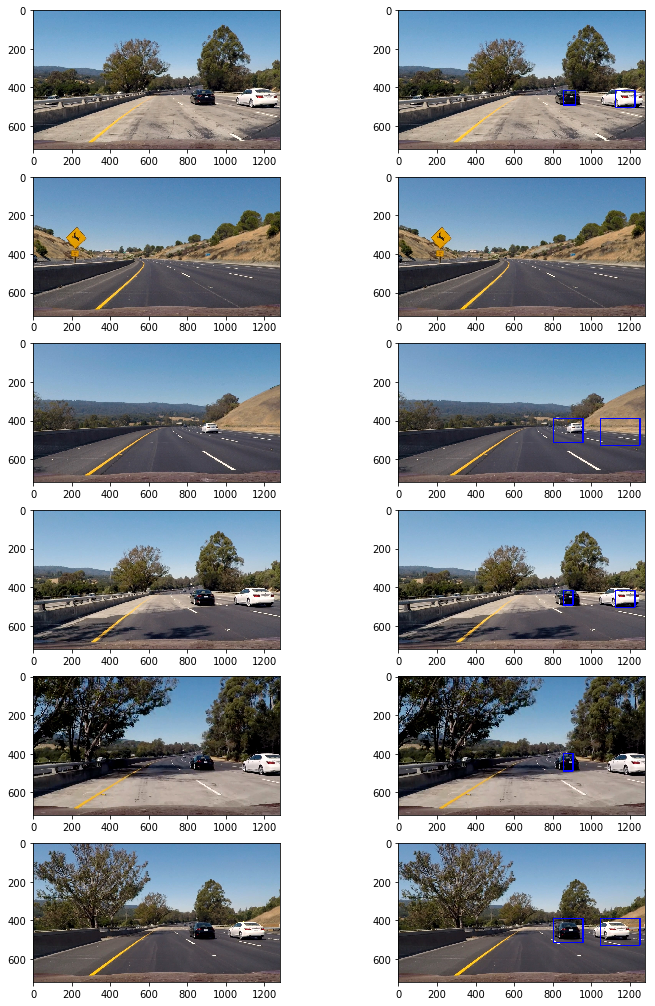

In [46]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



# global heatmaps
# heatmaps = [None, None, None]
# global count
# count = 0

#Parse the image that wants to be classified
def find_cars(img, show_heatmap = False, show_gray_squares = False, show_squares = False, m = False):
    global heatmaps
    predictions = []
    scale = 1.6
    ystart= 390
    ystop= 656

    orient = 9  # HOG orientations Improves upt to 9 then levels
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block

    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 60    # Number of histogram bins
    
    draw_image = np.copy(img)
    image = np.copy(img)
    img = img.astype(np.float32)/255
    heatmap = np.zeros_like(img[:,:,0])
    #Constrain area to search
    img_tosearch = img[ystart:ystop,:,:]
    #Color transform
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    # // divide and make sure output is integer
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1.1  # Instead of overlap, define how many cells to step #1.7
    nxsteps = int((nxblocks - nblocks_per_window) // cells_per_step)
    nysteps = int((nyblocks - nblocks_per_window) // cells_per_step)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = int(yb*cells_per_step)
            xpos = int(xb*cells_per_step)
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = int(xpos*pix_per_cell)
            ytop = int(ypos*pix_per_cell)

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #IMPORTANT: Stack featuers the same way as trained
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_image,bbox[0],bbox[1],(0,0,255),6)
                heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] +=1
                labels = label(heatmap)
                predictions.append(test_prediction)
    global count            
    if count >2:
        count = 1
        heatmap = cv2.add(heatmaps[0],heatmaps[1], heatmaps[2])
    else:
        count = count + 1
    print(count)
    heatmaps[count-1] = heatmap

    #if show_heatmap == True:
    heatmap = heatmap_thresh(heatmap, threshold=10.9)
    #heatmap = heatmap_thresh(heatmap, threshold=0.9)

    if 1 in predictions:
        labels = label(heatmap)
        img_label = labels[0]
        img_label = label_thresh(labels[0], threshold = 3)
        labels = label(img_label)
        #labels[0] = img_label
        draw_squares = draw_labeled_bboxes(image,labels)
        
        return draw_squares
        #return img_label
    else:
        #print("No car found")
        return image
    

titles = []
images_out = []
for img_file in img_files:
    img = mpimg.imread(img_file)
    result = find_cars(img)
    images_out.append(img)
    images_out.append(result)
    titles.append('')
    titles.append('')

    
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, images_out, titles)  
    


# image_example = mpimg.imread(img_files[2])
# result = find_cars(image_example)
# plt.imshow(result)


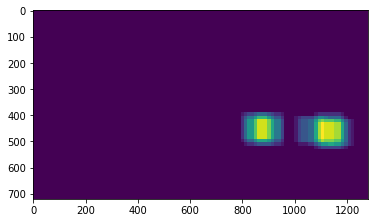

In [42]:
plt.imshow(heatmap)

In [ ]:
global heatmaps = []
global count = 0

#count = 0
if count >2:
    count = 1
    heatmap = cv2.add(heatmaps[0],heatmaps[1], heatmaps[2])
else:
    count +=1
    
heatmaps[count-1] = heatmap